# KBMOD Search for Multi-Night Results
  
A basic notebook to demonstrate searching results that appear across multiple nights.

Note that this notebook is intended to be run using shared data on baldur.

# Setup demo

Before importing, make sure you have installed kbmod using `pip install .` in the root `KBMOD` directory.  Also be sure you are running with python3 and using the correct notebook kernel.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os

import kbmod
from kbmod.analysis.plotting import *
from kbmod.data_interface import load_deccam_layered_image
from kbmod.search import ImageStack, PSF, StampCreator, Trajectory
from kbmod.results import Results
from kbmod.work_unit import WorkUnit
from kbmod.trajectory_generator import VelocityGridSearch
from kbmod.trajectory_utils import trajectory_predict_skypos

from kbmod.trajectory_explorer import TrajectoryExplorer

from astropy.coordinates import SkyCoord, search_around_sky
import astropy.units as u
from astropy.table import Table
import astropy.time 

import pandas as pd

In [72]:
# Data paths
wu_path = "/epyc/projects/kbmod/runs/coc123/reprojected/gscratch/dirac/coc123/reproject/20240611_a0c/42au/slice3/output/reprojected_wu.fits"
res_path = "/epyc/projects/kbmod/runs/coc123/reprojected/gscratch/dirac/coc123/reproject/20240611_a0c/42au/slice3/output_18993836_0"

# Path to known fakes (with reflex-corrected) coordinates on the dates used in this KBMOD search.
fakes_path = "/epyc/projects/kbmod/runs/wbeebe/fakes_cache_20190403_20190505.csv"

known_objects_path = "/epyc/projects/kbmod/coc123/common_files/region_search_df_A0_differenceExp_skybot_clean_simple_2019-04-03_and_2019-05-05.csv.gz"

# Reload a Saved KBMOD WorkUnit
Note that this WorkUnit was reflex-corrected with a guess distance of 42 AU.

By reloading the WorkUnit, we're able to recreate the stamps for individual observations in any given trajectory

In [3]:
wu = WorkUnit.from_fits(wu_path)

stack = wu.im_stack

print(f"Loaded stack with {stack.img_count()} images")

Setting unknown parameter: cluster_function
Setting unknown parameter: num_cores


Loaded stack with 195 images


# Reload KBMOD Results

A KBMOD run will store several files in its results directory. But we can generate a `Results` object (which wraps an astropy Table) from the `results.ecsv`

In [4]:
results = Results.read_table(os.path.join(res_path, "results.ecsv"))
results

<Results length=411>
  x     y            vx         ...   obs_valid             stamp          
int64 int64       float64       ...   bool[195]         float32[21,21]     
----- ----- ------------------- ... -------------- ------------------------
 4370  2053  -282.1337585449219 ... False .. False  717.7619 .. -109.379745
 1495  1048 -248.53103637695312 ...  True .. False     9950.07 .. 31158.945
  549   444  -266.9817199707031 ... False .. False   204.36348 .. 231.61069
  466  1195  -266.9219970703125 ...  True .. False    219.40419 .. 5.301999
 2617  1927   -262.034912109375 ... False .. False    223.75264 .. 75.58975
 1568  2011  -278.6114501953125 ...  True .. False    333.1805 .. 3.3705425
 1776   851 -267.97332763671875 ...  True .. False    13041.876 .. 734.0674
 3213   727 -250.71359252929688 ...  True .. False  1011.8828 .. -193475.66
 1778  1600  -271.9337463378906 ... False .. False   332.36435 .. 26.774828
  ...   ...                 ... ...            ...                      ...
 1487  3373  -16.71061897277832 ...   True .. True -67.715454 .. -14.764825
 4042  3128   -87.4455795288086 ...  False .. True    7.6502275 .. 22.73614
 2126  3846   -38.8935432434082 ... False .. False     44.18762 .. 24.22681
 3097  1594  -467.0014343261719 ...  True .. False   524.91486 .. 283.47305
 4179  1970  -342.4956359863281 ...  True .. False -42.933617 .. -31.580242
 1621  3657  -214.6995849609375 ...  True .. False   55.444397 .. 19.516891
 1581  1037  -291.3213195800781 ...  True .. False    280.0814 .. -47.52744
 3375  3000  -66.53223419189453 ...   True .. True   68.91348 .. -17.114859
 4535  3738  -459.7780456542969 ...  True .. False  3079.8135 .. -487.36465
 2217  4556 -41.791866302490234 ... False .. False         0.0 .. 14.319362

Let's reconstruct the trajectories from our saved results and recreate the stamps for each observation

In [5]:
trajectories = results.make_trajectory_list()
results.table["all_stamps"] = [StampCreator.get_stamps(stack, trj, 10) for trj in trajectories]

Add a column to our results for the number of unique days observed for each result based on the MJDs 

In [6]:
def mjd_to_day(mjd):
    # Takes a float mjd and converts to a string calendar date
    return str(astropy.time.Time(mjd, format='mjd').to_value('datetime')).split()[0]

# For each result find the number of unique days observed.
num_days = []
for idx in range(len(results)):
    # Whether an observation was "valid" and included in the result
    is_valid = results[idx]["obs_valid"]
    
    # Get all of the observation times that were valid and included in the result
    valid_obstimes = [] 
    for i in range(len(is_valid)):
        if is_valid[i]:
            valid_obstimes.append(stack.get_obstime(i))
    
    # Convert the obstimes to days and generate the number of days.
    num_days.append(len(set([mjd_to_day(t) for t in valid_obstimes])))

# Add as a column in the results table
results.table["num_days"] = num_days

Now for each result, we're interested in plotting the cumulative coadd as well as the coadds consisting only of the observations within a given day for that result.

In [7]:
# Generate coadds per each day to sanity check against the fakes.
def plot_daily_coadds(result_table, result_idx):
    # Map each day for a result to its coadded stamp
    daily_coadds = {}
    result_row = result_table[result_idx]
    for i in range(stack.img_count()):
        if result_row["obs_valid"][i]:
            day = mjd_to_day(stack.get_obstime(i))
            curr_stamp = result_row["all_stamps"][i]
            # Depending on where "all_stamps" is generated may be a RawImage
            if not isinstance(curr_stamp, np.ndarray):
                curr_stamp = curr_stamp.image

            if day not in daily_coadds:
                # Create the initial coadd
                daily_coadds[day] = curr_stamp.copy()
            else:
                # Add the stamps together
                daily_coadds[day] += curr_stamp
    
    # First we'll plot the full coadd
    imgs = [result_table["stamp"][result_idx]]
    labels = [f'Coadd for result {result_idx}']
    
    # Add images and labels for each individual day
    for day in daily_coadds:
        imgs.append(daily_coadds[day])
        labels.append(str(day))
    
    plot_multiple_images(imgs, labels=labels, norm=True)

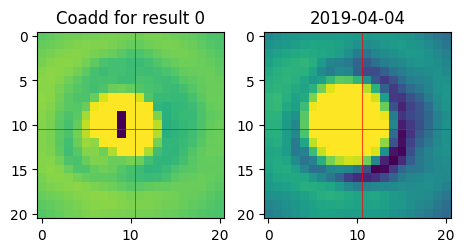

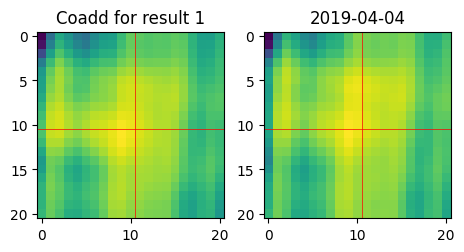

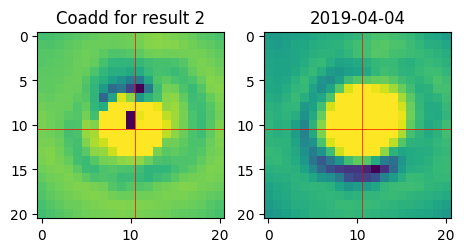

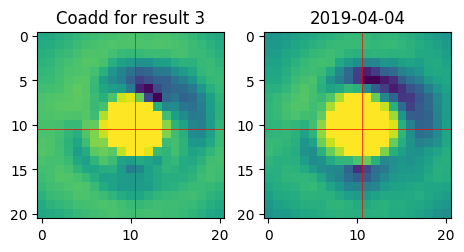

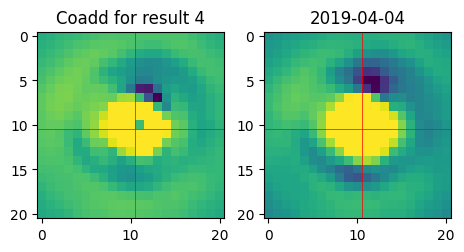

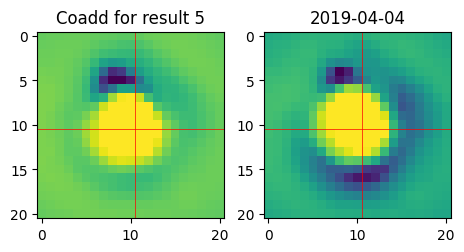

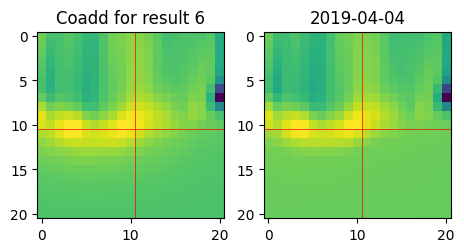

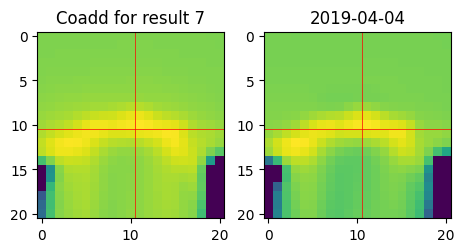

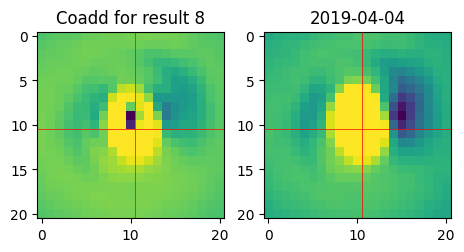

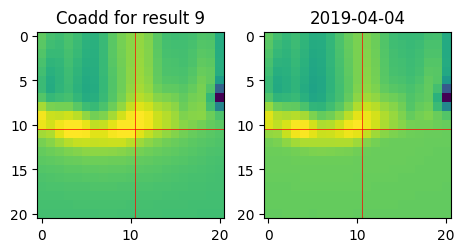

In [8]:
for i in range(min(len(results),10)):
    plot_daily_coadds(results, i)

/astro/users/wbeebe/.conda/envs/kbmod_new_wu/lib/python3.12/site-packages/kbmod/analysis/plotting.py:448: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(layout="constrained")


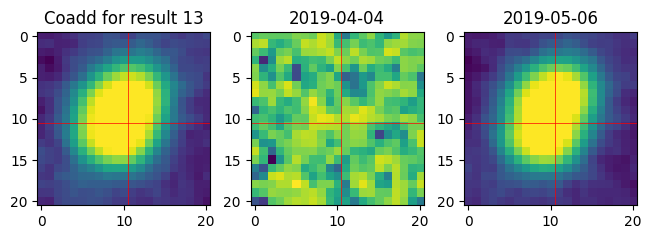

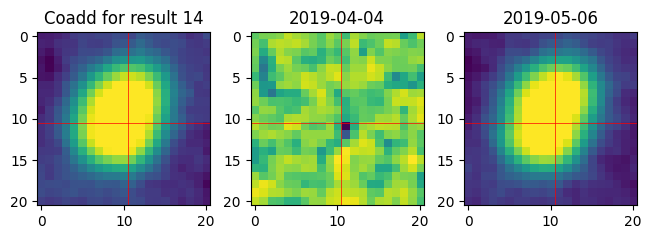

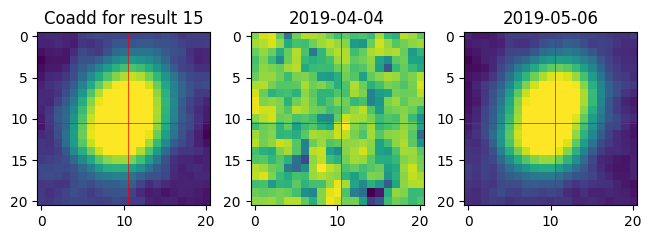

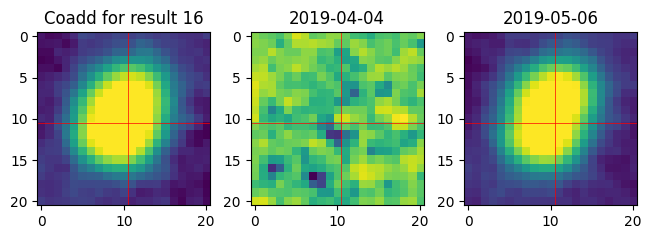

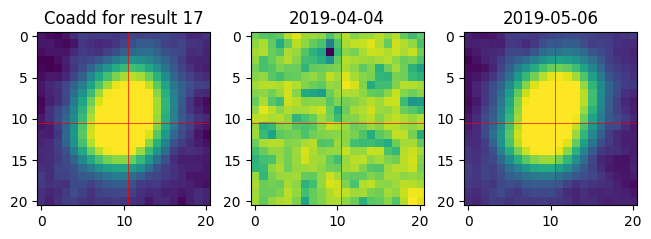

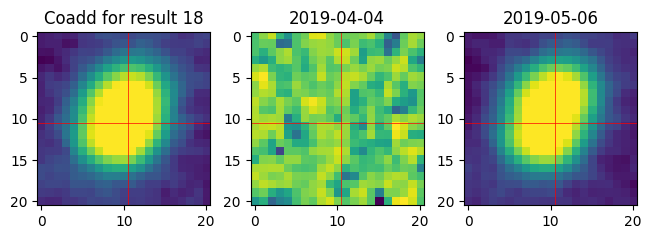

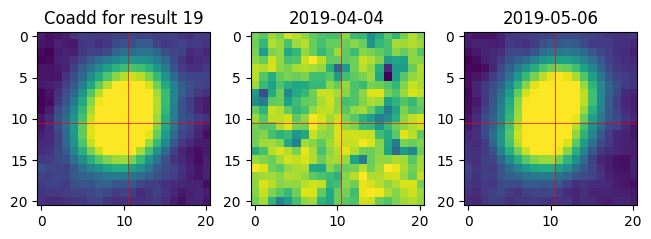

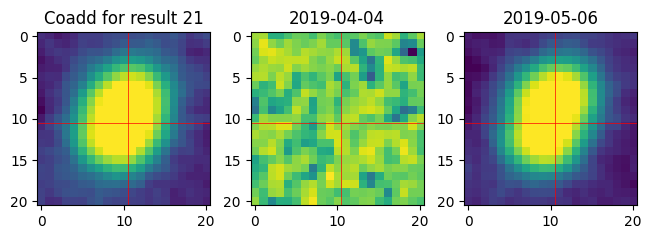

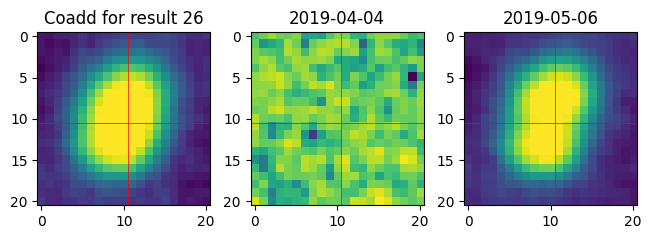

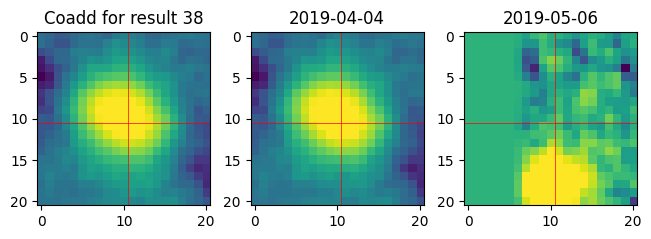

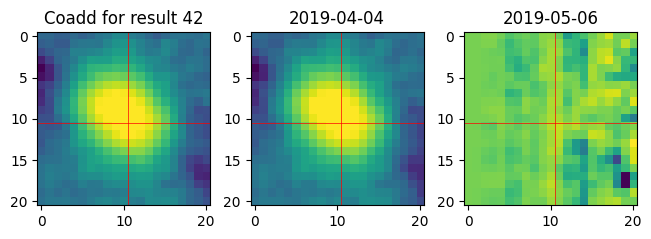

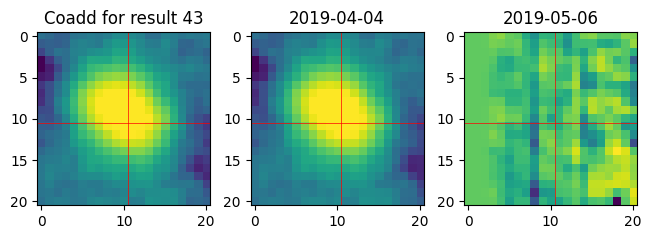

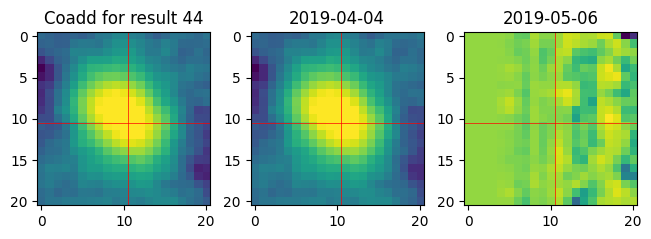

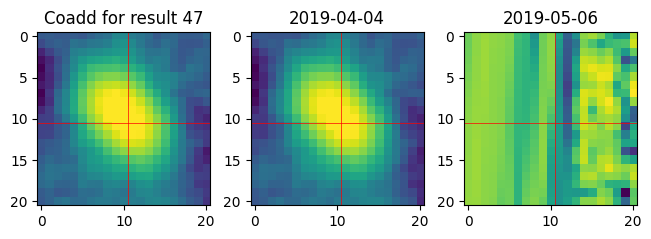

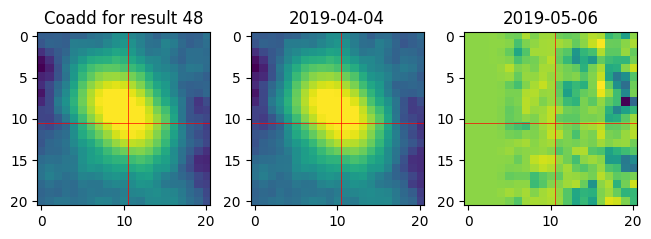

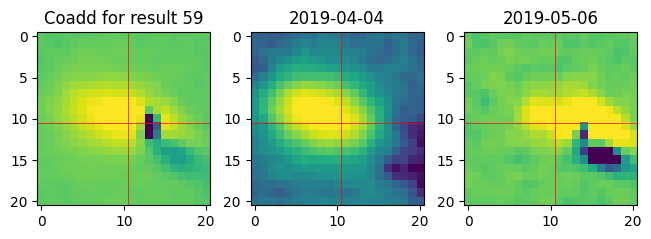

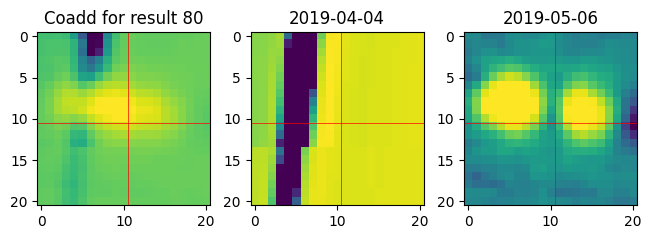

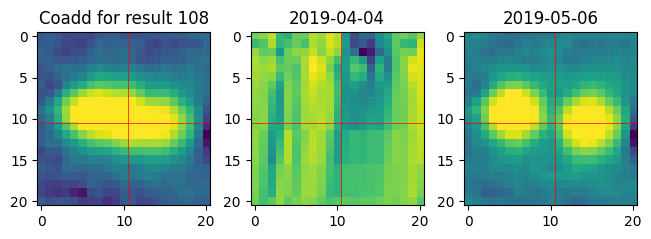

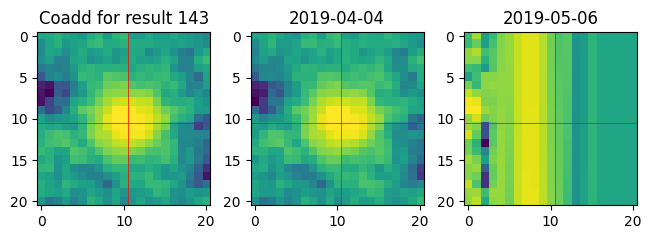

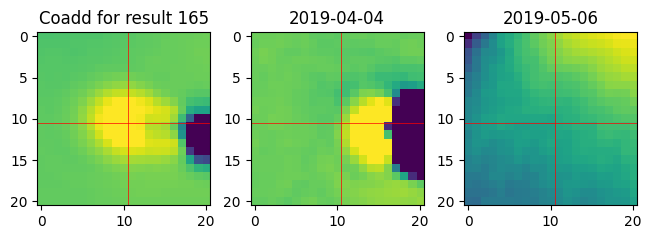

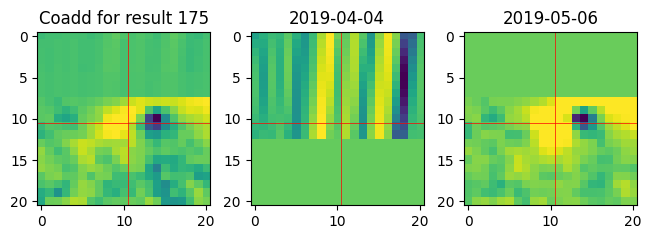

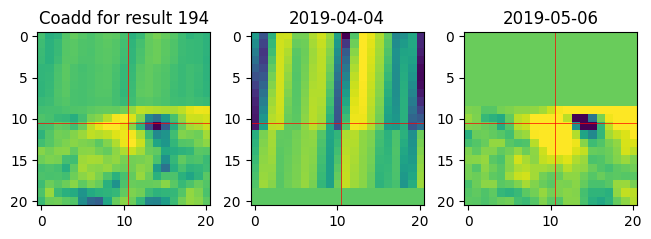

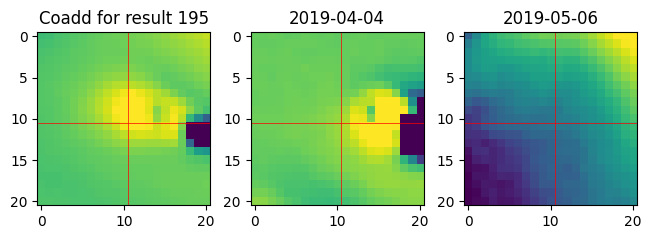

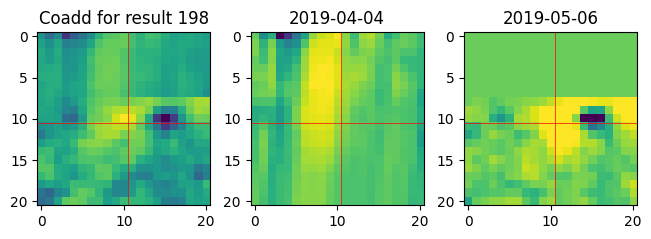

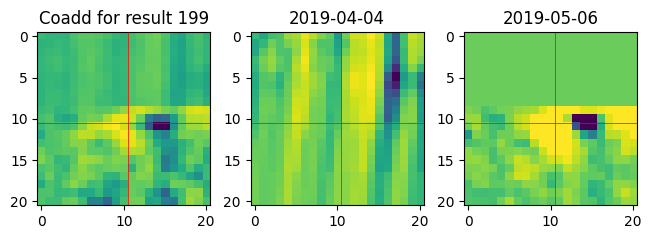

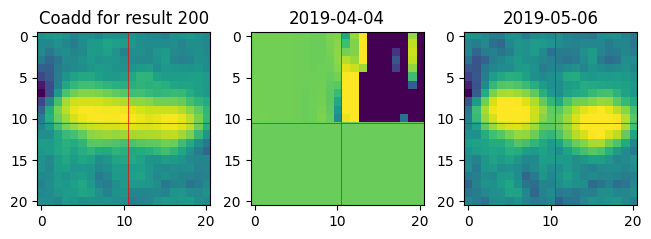

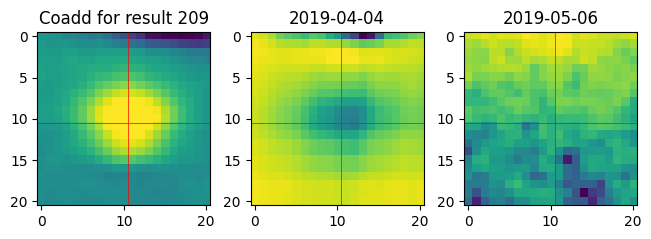

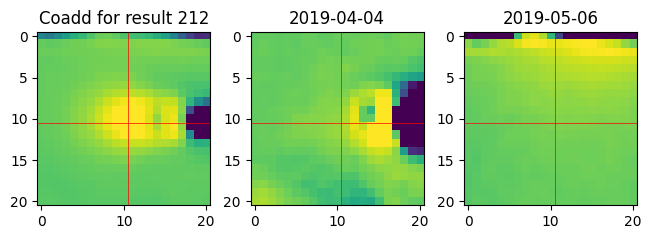

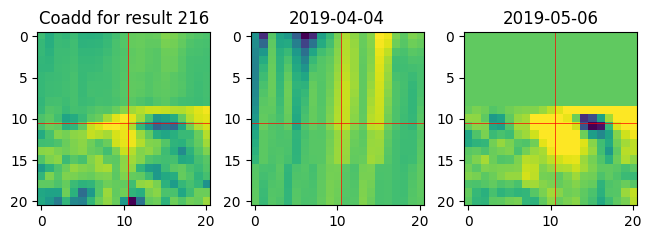

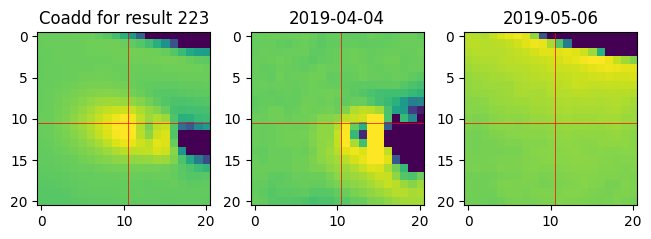

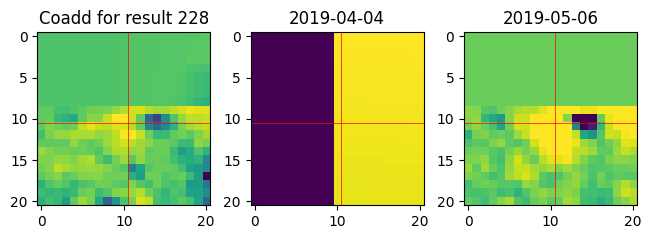

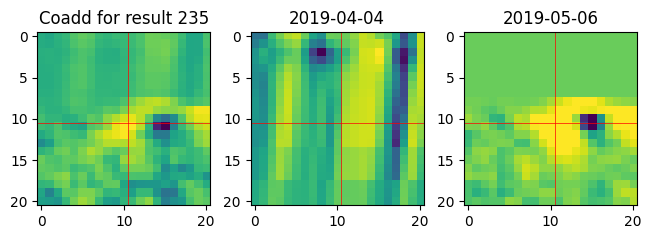

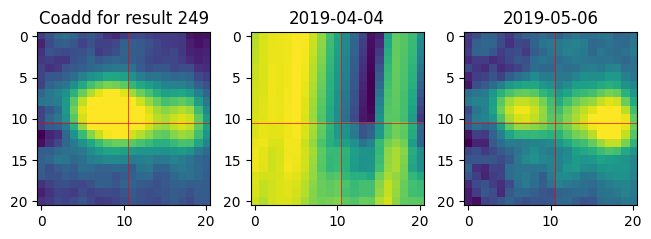

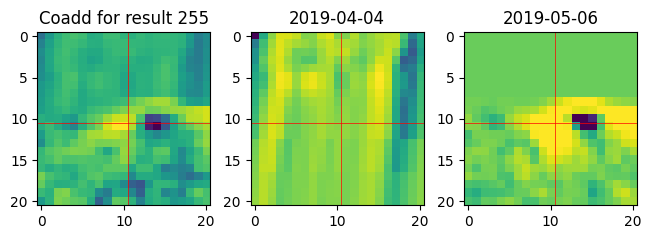

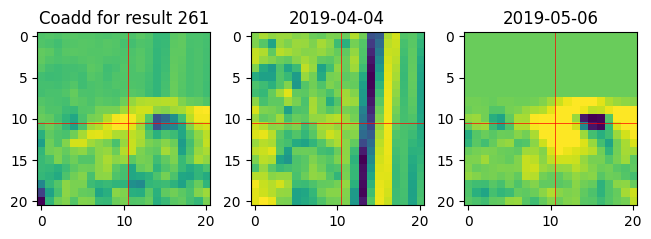

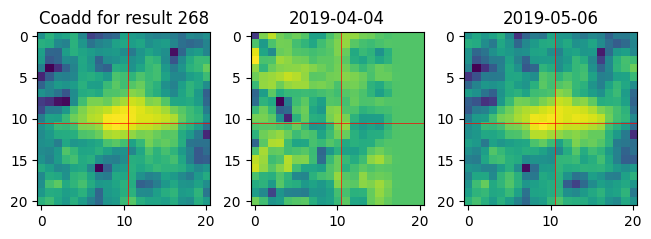

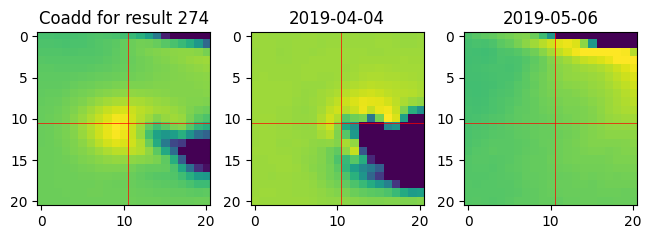

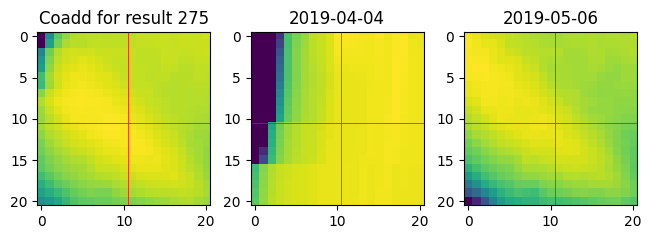

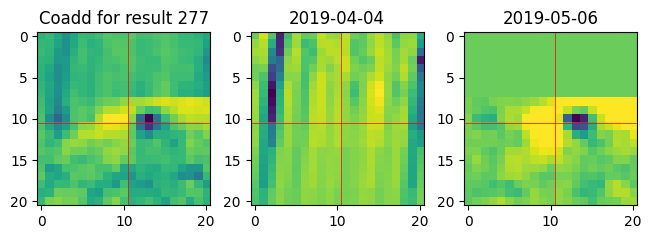

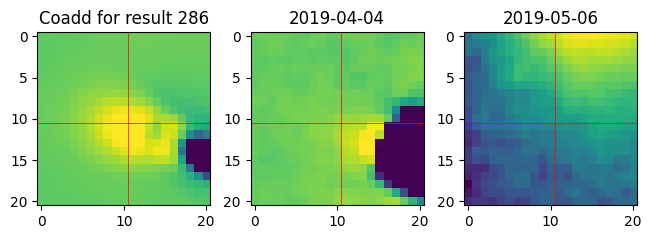

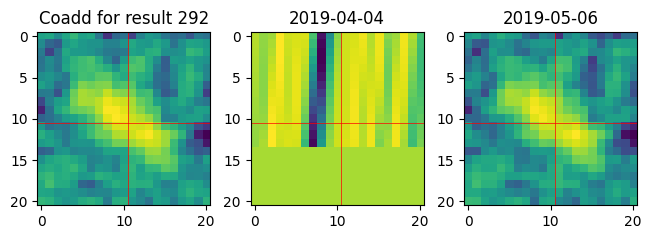

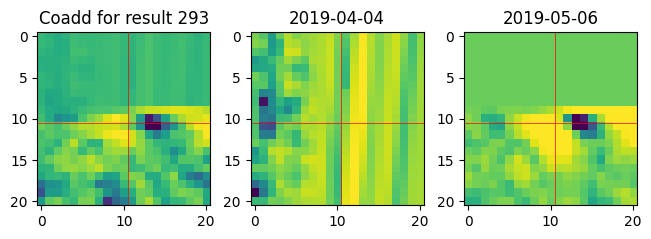

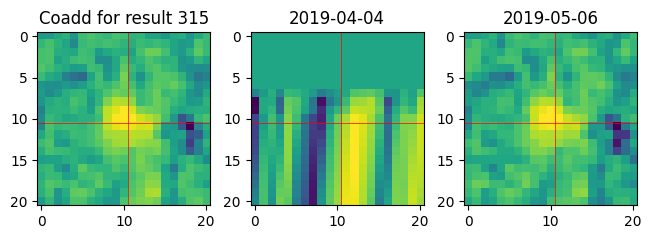

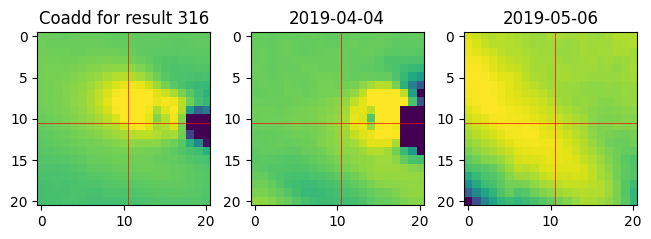

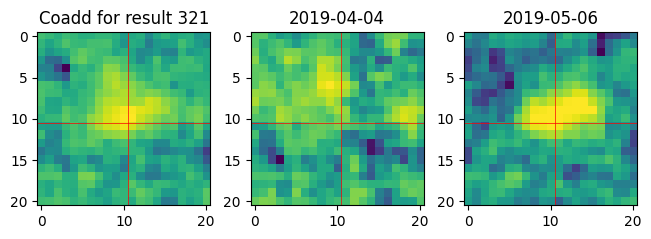

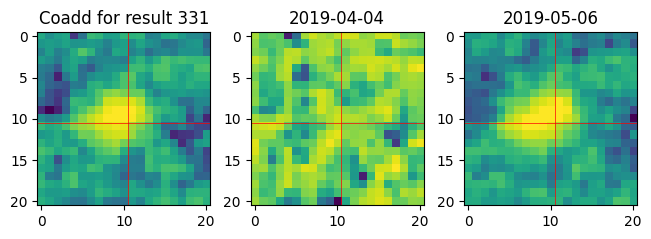

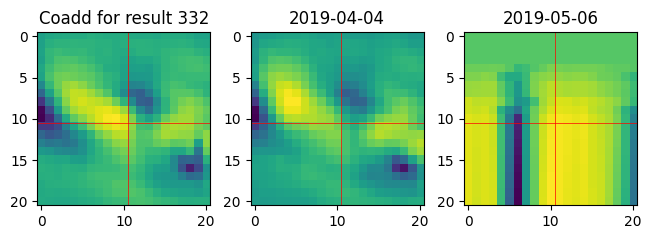

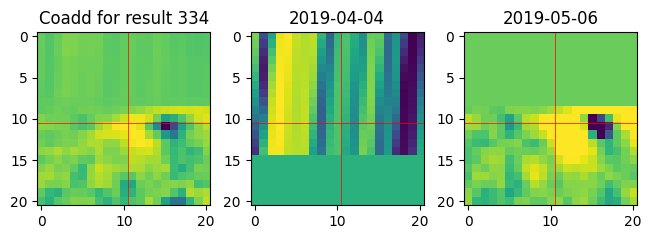

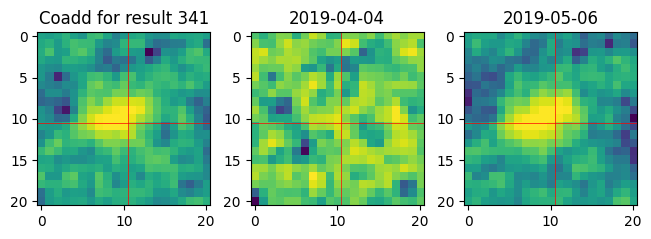

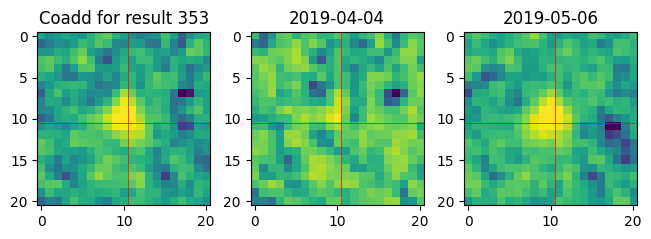

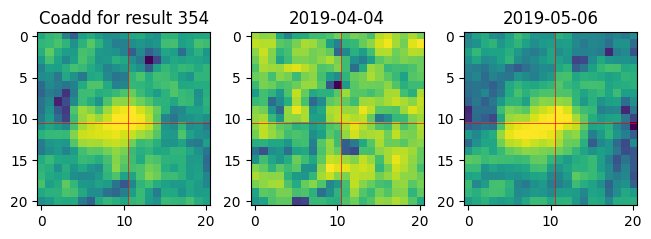

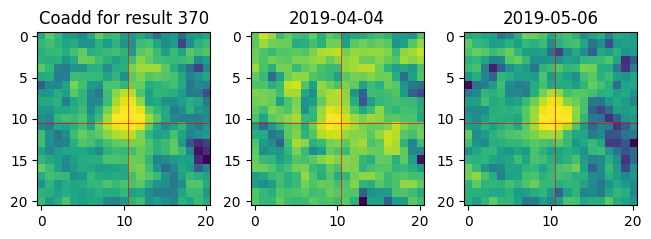

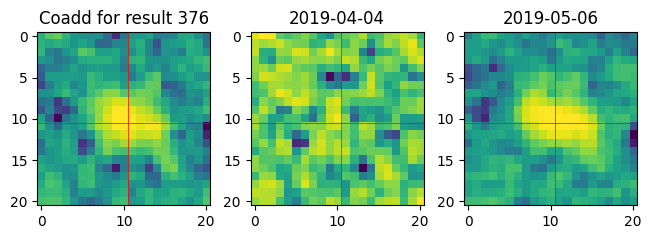

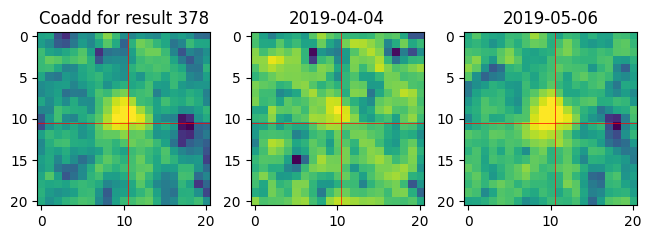

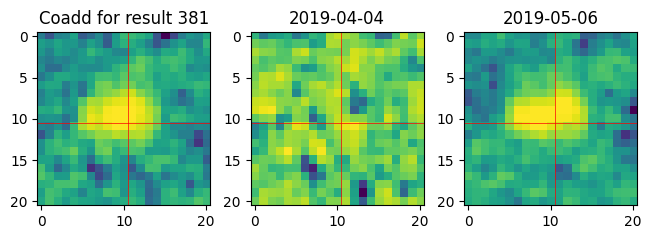

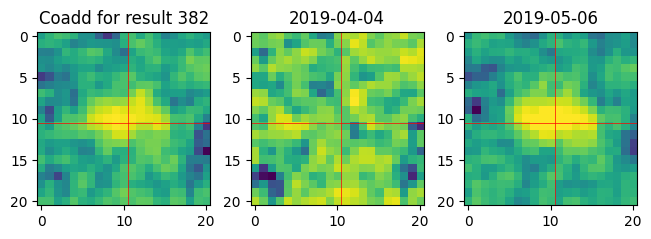

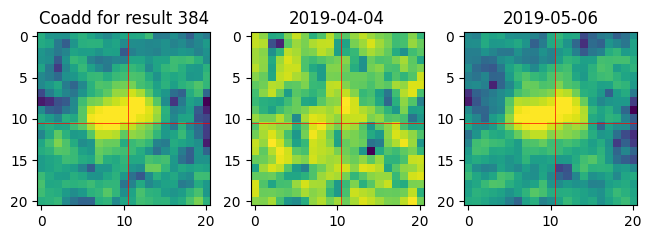

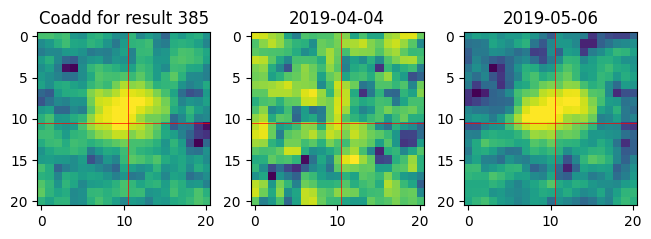

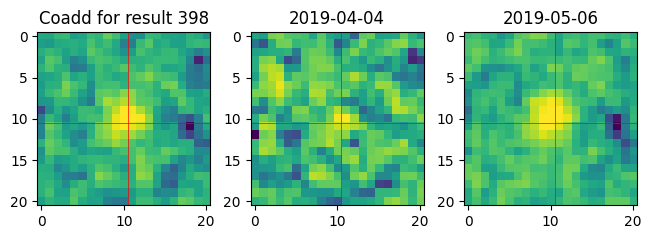

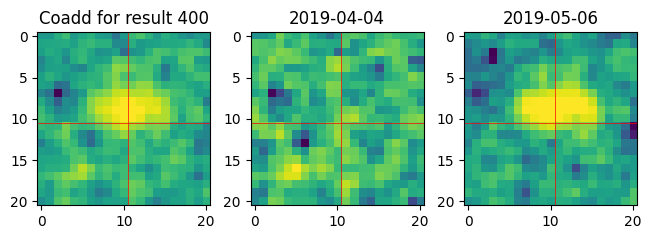

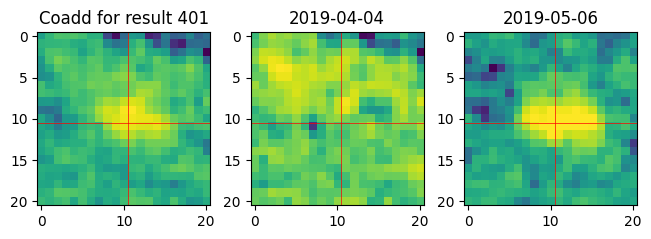

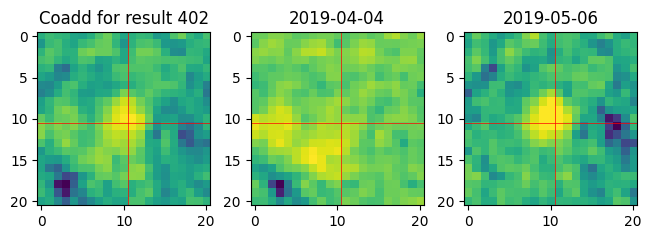

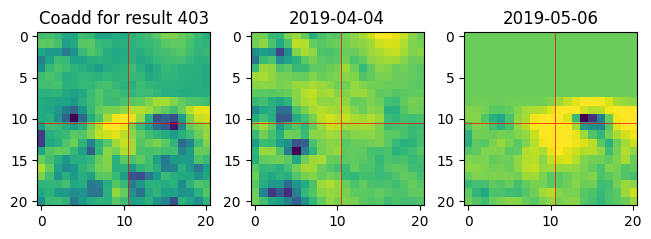

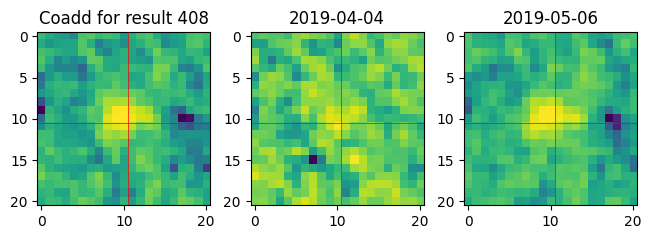

In [9]:
for i in range(len(results)):
    if results[i]["num_days"] >= 2:
        plot_daily_coadds(results, i)

# Search for results that are near known fakes

We have a table of fakes that are present in the data, uniquely identified by the 'ORBITID' column

In [10]:
fakes = Table.read(fakes_path, format="csv")
fakes.sort(["ORBITID", "mjd_mid"]) # Sort by the unique ORBITID for each fake and then observation time
fakes

<Table length=177890>
Unnamed: 0          RA                 DEC         ... DEEP_id large_pile
  int64          float64             float64       ...   str3     str5   
---------- ------------------- ------------------- ... ------- ----------
       317  -143.9352217876162  -11.23051029609669 ...     A0c       True
       318  -143.9352396609452 -11.230502318364524 ...     A0c       True
       319  -143.9352582170883 -11.230494035731535 ...     A0c       True
       320  -143.9352760911034 -11.230486057428031 ...     A0c       True
       321 -143.93529399904745 -11.230478063822083 ...     A0c       True
       322 -143.93531192593898 -11.230470061582771 ...     A0c       True
       323 -143.93532985351277 -11.230462058845076 ...     A0c       True
       324 -143.93534786129106 -11.230454020091338 ...     A0c       True
       325  -143.9353656936292 -11.230446059427496 ...     A0c       True
       ...                 ...                 ... ...     ...        ...
   4665715 -144.46314034771504 -11.566228201246924 ...     A0c       True
   4665716 -144.46315408149596 -11.566224357222644 ...     A0c       True
   4665717 -144.46316790332276  -11.56622048768944 ...     A0c       True
   4665718 -144.46318171972865 -11.566216618804724 ...     A0c       True
   4665807 -144.73334294346228 -11.492884905104043 ...     A0a      False
   4665808  -144.7333581977868  -11.49288102740951 ...     A0a      False
   4665809 -144.73337327687094 -11.492877194493374 ...     A0a      False
   4665810 -144.73481542648452 -11.492510360398292 ...     A0a      False
   4665811 -144.73483059731245 -11.492506485607848 ...     A0a      False
   4665812 -144.73484583783167 -11.492502592438608 ...     A0a      False

astropy allows us to take two catalogus of coordinates (represented by `SkyCoord` objects) and easily search for nearest neighbors between them. 

First, as a simple approximation let's translate the initial (x, y) of each of our results into an (ra, dec). Note that we are using a reflex-corrected WCS from our `WorkUnit` so the (ra, dec) will be in reflex-corrected space.

In [11]:
def get_ra_decs_from_trj(idx, result_table, trajectories):
    # To generate a trajectory object we need times of each valid observation for this result
    is_valid = result_table[idx]["obs_valid"]
    valid_obstimes = []
    for i in range(len(is_valid)):
        if is_valid[i]:
            valid_obstimes.append(stack.get_obstime(i))
    
    # Now we can generate (ra, DEC) coordinates for the trajectory using our work unit's WCS
    return trajectory_predict_skypos(trajectories[idx], wu.wcs, valid_obstimes)

ra_decs = [get_ra_decs_from_trj(i, results, trajectories) for i in range(len(results))]

results.table["ra_dec_start"] = [ra_decs[i][0] for i in range(len(results))]
results.table["ra_dec_end"] = [ra_decs[i][-1] for i in range(len(results))]

In [12]:
fakes_guess_ra = "RA_42.0"
fakes_guess_dec = "Dec_42.0"

Now we can translate our (ra, dec) pairs into single `SkyCoord` objects.

Then we can use astopy's `search_around_sky` to find which KBMOD results are near our known fakes, with a max separation limit of 1 arcsecond

In [13]:
# Get the reflex-corrected (ra, DEC) positions for our fakes  
fake_coords = SkyCoord(ra=fakes[fakes_guess_ra] * u.degree, dec=fakes[fakes_guess_dec] * u.degree)

# Performe the search for if our trajectory start positions were near any fakes
idx1, idx2, sep2dAngle, dist3d = search_around_sky(results["ra_dec_start"], fake_coords, 1 * u.arcsecond)

`idx1` Maps fakes to their nearest neighbors in the results. Each value is an index to a potential finding within our results table.

In [14]:
print(len(idx1))
idx1

1521


array([ 30,  30,  30, ..., 395, 395, 395])

In [15]:
idx2

array([96046, 96047, 96048, ..., 13732, 13733, 13734])

In [16]:
potential_fake_starts = np.unique(idx1)
potential_fake_starts

array([ 30,  31,  32,  33,  34,  36,  37,  38,  42,  43,  44,  47,  48,
       100, 105, 110, 122, 123, 134, 137, 142, 143, 144, 146, 280, 320,
       344, 369, 391, 395])

Let's first examine the first result which we believe might be a fake.

In [17]:
results[potential_fake_starts[0]]

<Row index=30>
  x     y           vx                 vy            likelihood           flux       obs_count         psi_curve                   phi_curve             obs_valid             stamp                                                        all_stamps                                              num_days             ra_dec_start                          ra_dec_end             
                                                                                                                                                                                                                                                                                                                           deg,deg                              deg,deg               
int64 int64      float64            float64           float64           float64        int64          float64[195]                float64[195]           bool[195]         float32[21,21]                                                  object[195]                                               int64                 SkyCoord                             SkyCoord              
----- ----- ------------------ ----------------- ----------------- ----------------- --------- ------------------------- ----------------------------- ------------- ------------------------- ---------------------------------------------------------------------------------------------------- -------- ----------------------------------- -------------------------------------
 4116  1411 -8.492758750915527 -5.27949333190918 131.3669981223843 687.6497108004615       102 0.3040344715118408 .. 0.0 0.00041880112257786095 .. 0.0 True .. False -47.675484 .. -102.814995 <kbmod.search.RawImage object at 0x7fa6e58ccfb0> .. <kbmod.search.RawImage object at 0x7fa6e58e1c30>        1 216.362792870326,-12.23015443374774 216.3629060785552,-12.230223289872477

/astro/users/wbeebe/.conda/envs/kbmod_new_wu/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/astro/users/wbeebe/.conda/envs/kbmod_new_wu/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


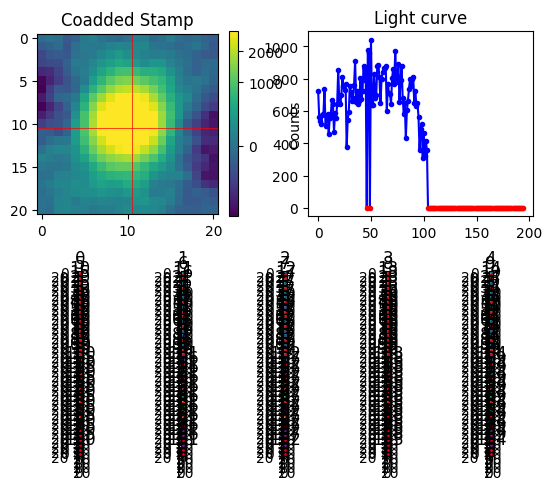

In [18]:
# helper function to plot a row of the results table
#plot_result_row(results[potential_fake_starts[0]])

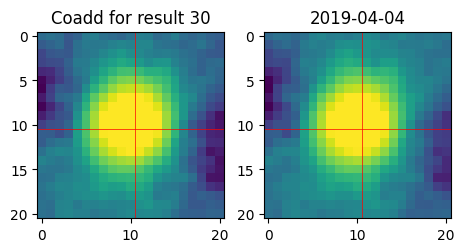

In [19]:
plot_daily_coadds(results, potential_fake_starts[0])

`idx2` shows the inverse mapping of which fakes might be potential results. Here its values are indices within our fakes table.

So taking the first potential match we examined above, we can use the corresponding index (in this case 0) to inspect within our fakes table.


In [20]:
fakes[idx2[0]]["ORBITID"]

3316134

In [21]:
def find_fakes_matches(fakes_table, idx1, idx2):
    # Matches a result's index index in the results table to its corresponding fake orbit ID
    matches = {}
    for i in range(len(idx1)):
        if idx1[i] not in matches:
            matches[idx1[i]] = set()
        matches[idx1[i]].add(fakes[idx2[i]]["ORBITID"])
        
    return matches
    
result_start_to_fakes = find_fakes_matches(fakes, idx1, idx2)
result_start_to_fakes
    

{30: {3316134},
 31: {3316134},
 32: {3316134},
 33: {3316134},
 34: {386446},
 36: {3316134},
 37: {386446},
 38: {386446},
 42: {386446},
 43: {386446},
 44: {386446},
 47: {386446},
 48: {386446},
 100: {2165936},
 105: {2165936},
 110: {2165936},
 122: {2165936},
 123: {2165936},
 134: {2165936},
 137: {2165936},
 142: {2165936},
 143: {2165936},
 144: {2165936},
 146: {2165936},
 280: {3123444},
 320: {460414},
 344: {460414},
 369: {460414},
 391: {460414},
 395: {460414}}

In [22]:
fakes[fakes["ORBITID"] == 4661373]

<Table length=18>
Unnamed: 0          RA                 DEC         ... DEEP_id large_pile
  int64          float64             float64       ...   str3     str5   
---------- ------------------- ------------------- ... ------- ----------
   3544249 -143.98354232177616 -13.852867423173404 ...     A0b      False
   3544250 -143.98356484840582 -13.852861613522494 ...     A0b      False
   3544251 -143.98358753226222  -13.85285576271693 ...     A0b      False
   3544252  -143.9860994559045 -13.852201360439787 ...     A0b      False
   3544253  -143.9861221447752 -13.852195373319832 ...     A0b      False
   3544254 -143.98614480480524  -13.85218939228786 ...     A0b      False
   3544255 -143.98616915687012 -13.852182962954728 ...     A0b      False
   3544256  -143.9861916051493 -13.852177034696185 ...     A0b      False
   3544257 -143.98621412038156  -13.85217108725838 ...     A0b      False
   3544258  -143.9862367992477  -13.85216509508066 ...     A0b      False
   3544259  -143.9862592496635 -13.852159161766432 ...     A0b      False
   3544260 -143.98628190542826 -13.852153172672908 ...     A0b      False
   3544267 -144.42966483389077  -13.73368584582975 ...     A0b      False
   3544268 -144.42969004283216  -13.73367925139325 ...     A0b      False
   3544269  -144.4297146583923 -13.733672812412271 ...     A0b      False
   3544270 -144.43208938509312 -13.733050377812988 ...     A0b      False
   3544271 -144.43211460359876 -13.733043731686331 ...     A0b      False
   3544272 -144.43213968514664 -13.733037120484918 ...     A0b      False

# Now see if the end points of any of the trajectories are also near the endpoints of our fakes

In [23]:
idx1_end, idx2_end, sep2dAngle_end, dist3d_end = search_around_sky(results["ra_dec_end"], fake_coords, 1 * u.arcsecond)

In [24]:
idx1_end

array([ 13,  13,  13, ..., 408, 408, 408])

In [25]:
idx2_end

array([109152, 109153, 109154, ..., 169184, 169185, 169186])

In [26]:
potential_fake_ends = np.unique(idx1_end)
potential_fake_ends

array([ 13,  14,  15,  16,  17,  18,  19,  21,  26,  30,  31,  32,  33,
        34,  36,  37,  41, 100, 105, 110, 122, 123, 134, 137, 140, 142,
       144, 146, 155, 157, 167, 200, 267, 268, 280, 315, 320, 321, 331,
       341, 344, 353, 354, 369, 370, 378, 381, 382, 384, 385, 395, 398,
       400, 401, 402, 408])

In [27]:
result_end_to_fakes = find_fakes_matches(fakes, idx1_end, idx2_end)
result_end_to_fakes

{13: {3727110},
 14: {3727110},
 15: {3727110},
 16: {3727110},
 17: {3727110},
 18: {3727110},
 19: {3727110},
 21: {3727110},
 26: {3727110},
 30: {3316134},
 31: {3316134},
 32: {3316134},
 33: {3316134},
 34: {386446},
 36: {3316134},
 37: {386446},
 41: {3316134},
 100: {2165936},
 105: {2165936},
 110: {2165936},
 122: {2165936},
 123: {2165936},
 134: {2165936},
 137: {2165936},
 140: {2165936},
 142: {2165936},
 144: {2165936},
 146: {2165936},
 155: {2165936},
 157: {2165936},
 167: {2165936},
 200: {1601503},
 267: {3123444},
 268: {953606},
 280: {3123444},
 315: {6001643},
 320: {460414},
 321: {953606},
 331: {953606},
 341: {953606},
 344: {460414},
 353: {6001643},
 354: {953606},
 369: {460414},
 370: {6001643},
 378: {6001643},
 381: {953606},
 382: {953606},
 384: {953606},
 385: {953606},
 395: {460414},
 398: {6001643},
 400: {953606},
 401: {953606},
 402: {6001643},
 408: {6001643}}

# Look for Fakes Matching Both the Start and Endpoint

In [28]:
# Maps of result indices that could be matched to a fake for both their start and end coordinate
result_full_fake_match = {}
for r in result_start_to_fakes:
    # Check for results that also were matched to a fake for their end coordinate
    if r in result_end_to_fakes:
        shared_fakes = result_start_to_fakes[r].intersection(result_end_to_fakes[r])
        if len(shared_fakes) > 0:
            result_full_fake_match[r] = shared_fakes
result_full_fake_match

{30: {3316134},
 31: {3316134},
 32: {3316134},
 33: {3316134},
 34: {386446},
 36: {3316134},
 37: {386446},
 100: {2165936},
 105: {2165936},
 110: {2165936},
 122: {2165936},
 123: {2165936},
 134: {2165936},
 137: {2165936},
 142: {2165936},
 144: {2165936},
 146: {2165936},
 280: {3123444},
 320: {460414},
 344: {460414},
 369: {460414},
 395: {460414}}

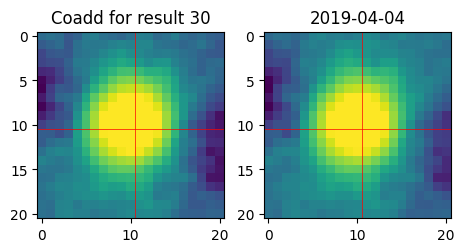

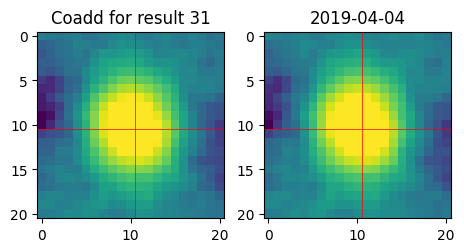

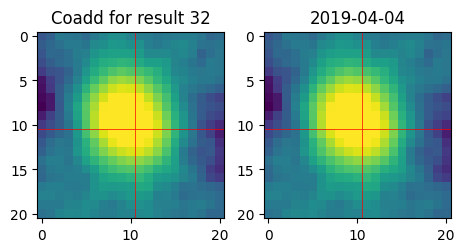

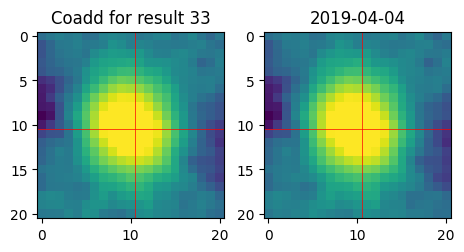

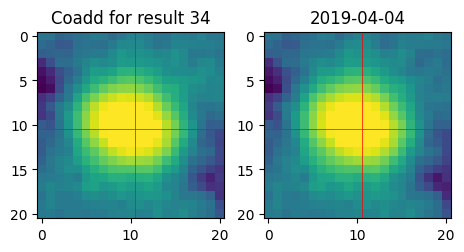

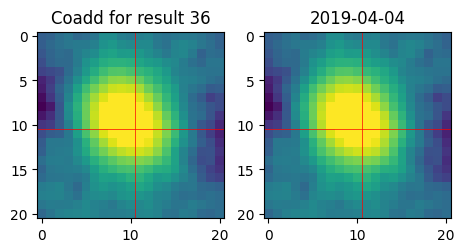

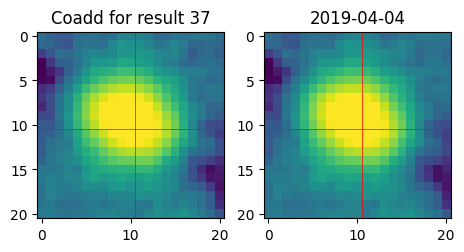

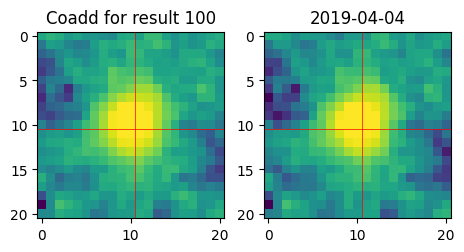

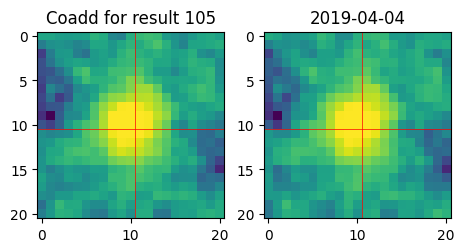

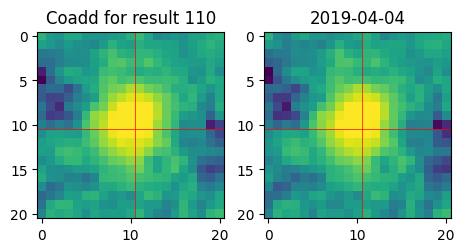

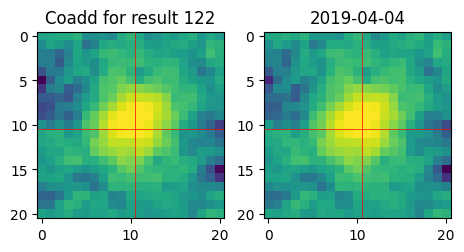

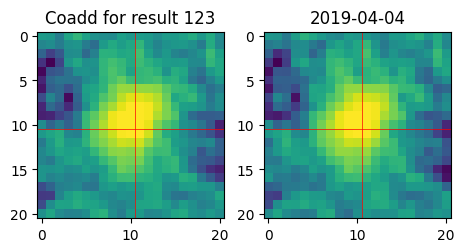

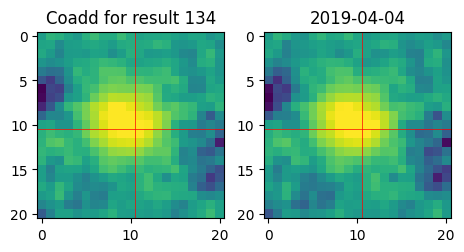

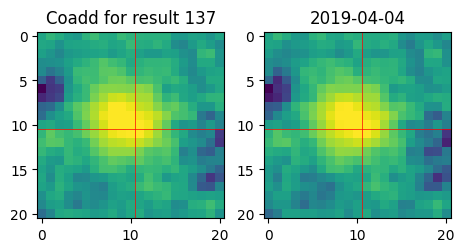

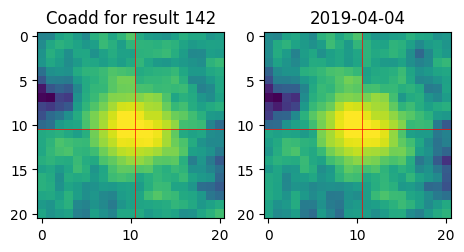

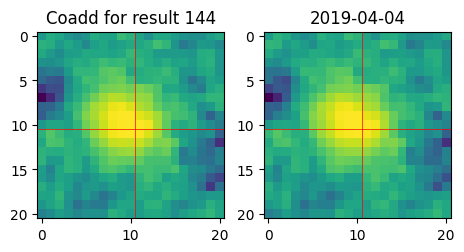

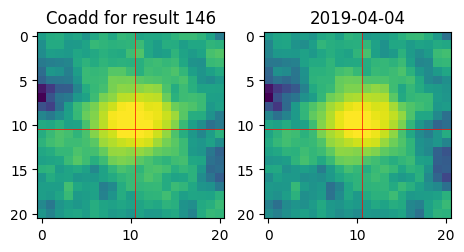

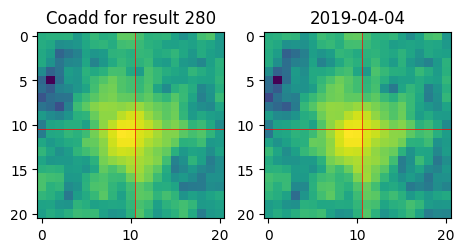

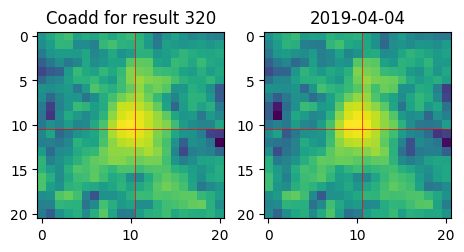

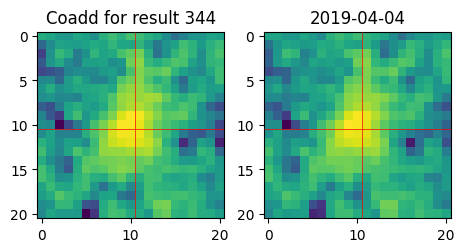

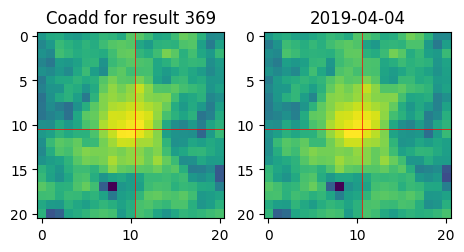

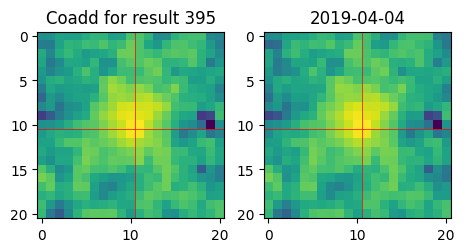

In [29]:
for idx in result_full_fake_match:
    plot_daily_coadds(results, idx)

Result 6 is interesting, so let's examine its matching fake(s)

# Plot a Given KBMOD Result Trajectory Alongside a Given Fake

In the next cell we provide a variety of helper functions for evaluating a KBMOD trajectory alongside a given fake

In [ ]:
def get_x_y_from_trj(idx, result_table, trajectories, times):
    dt = np.array(times)
    dt -= dt[0]

    trj = trajectories[idx]
    # Predict locations in pixel space.
    x_vals = trj.x + trj.vx * dt
    y_vals = trj.y + trj.vy * dt

    return x_vals, y_vals

def plot_res_traj(result_table, res_idx, trajectories):
    valid_obstimes = []
    for i in range(len(result_table[res_idx]["obs_valid"])):
        if result_table[res_idx]["obs_valid"][i]:
            valid_obstimes.append(stack.get_obstime(i))
    
    res_x, res_y = get_x_y_from_trj(res_idx, result_table, trajectories, valid_obstimes)
    
    min_date = min(valid_obstimes)
    max_date = max(valid_obstimes)
    day_sep = int(max_date) - int(min_date)

    kbmod_plt = plt.scatter(res_x, res_y, color='blue', label="KBMOD trajectory", marker='.')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.title(f'KBMOD Result Trajectory {res_idx} ({day_sep} day separation)')
    plt.show()

def plot_fake(fake_table, orbit_id):
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    fake_x, fake_y = wu.wcs.world_to_pixel(SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree))
    
    min_date = min(our_fake["mjd_mid"])
    max_date = max(our_fake["mjd_mid"])
    day_sep = int(max_date) - int(min_date)

    fake_plt = plt.scatter(fake_x, fake_y, color='red', label="fakes", marker='.')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.title(f'Fake ORBIT_ID={orbit_id} ({day_sep} day separation)')
    plt.show()
    
def plot_fake_ra_dec(fake_table, orbit_id):
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    #fake_x, fake_y = SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree)
    
    min_date = min(our_fake["mjd_mid"])
    max_date = max(our_fake["mjd_mid"])
    day_sep = int(max_date) - int(min_date)

    fake_plt = plt.scatter(our_fake[fakes_guess_ra], our_fake[fakes_guess_dec], color='red', label="fakes", marker='.')
    plt.xlabel('ra (degrees)')
    plt.ylabel('dec (degrees)')
    plt.title(f'Fake ORBIT_ID={orbit_id} ({day_sep} day separation)')
    plt.show()
    
def plot_fake_ra_dec_single_night(fake_table, orbit_id, night):
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    our_fake =  our_fake[our_fake["local_obsnight"] == night]
    #fake_x, fake_y = SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree)
    
    min_date = min(our_fake["mjd_mid"])
    max_date = max(our_fake["mjd_mid"])
    day_sep = int(max_date) - int(min_date)

    fake_plt = plt.scatter(our_fake[fakes_guess_ra], our_fake[fakes_guess_dec], color='red', label="fakes", marker='.')
    plt.xlabel('ra (degrees)')
    plt.ylabel('dec (degrees)')
    plt.title(f'Fake ORBIT_ID={orbit_id} ({night})')
    plt.show()
    
def plot_fake_x_y_single_night(fake_table, orbit_id, night):
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    our_fake =  our_fake[our_fake["local_obsnight"] == night]
    fake_x, fake_y = wu.wcs.world_to_pixel(SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree))
    
    min_date = min(our_fake["mjd_mid"])
    max_date = max(our_fake["mjd_mid"])
    day_sep = int(max_date) - int(min_date)

    fake_plt = plt.scatter(fake_x, fake_y, color='red', label="fakes", marker='.')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.title(f'Fake ORBIT_ID={orbit_id} ({night})')
    plt.show()
    
    
def plot_res_traj_and_fake(result_table, res_idx, trajectories, fake_table, orbit_id):
    valid_obstimes = []
    for i in range(len(result_table[res_idx]["obs_valid"])):
        if result_table[res_idx]["obs_valid"][i]:
            valid_obstimes.append(stack.get_obstime(i))
    
    res_x, res_y = get_x_y_from_trj(res_idx, result_table, trajectories, valid_obstimes)
    
    our_fake = fake_table[fake_table["ORBITID"] == orbit_id]
    fake_x, fake_y = wu.wcs.world_to_pixel(SkyCoord(ra=our_fake[fakes_guess_ra]*u.deg, dec=our_fake[fakes_guess_dec]*u.degree))
    
    min_date = min(min(valid_obstimes), min(our_fake["mjd_mid"]))
    max_date = max(max(valid_obstimes), max(our_fake["mjd_mid"]))
    day_sep = int(max_date) - int(min_date)

    kbmod_plt = plt.scatter(res_x, res_y, color='blue', label="KBMOD trajectory", marker='|',  alpha=0.5)
    fake_plt = plt.scatter(fake_x, fake_y, color='red', label="fakes", marker='_',  alpha=0.5)
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.title(f'KBMOD Result Trajectory {res_idx} vs Fake ORBIT_ID={orbit_id} ({day_sep} day separation)')
    plt.legend((kbmod_plt, fake_plt), ("KBMOD trajectory", "fake"))
    plt.show()
    

In [ ]:
plot_fake(fakes, CURR_ORBIT_ID)

# We can also take a fake and generate a KBMOD search config specifically to find it

We can calculate the pixel space velocity of our reflex-corrected fake and then generate a VelocityGridSearch for a targeted run of KBMOD.

See https://github.com/dirac-institute/kbmod/blob/main/docs/source/user_manual/search_space.rst#velocitygridsearch

In [ ]:
base_config = kbmod.configuration.SearchConfiguration.from_file(os.path.join(res_path, "search_config.yaml"))

def create_velocity_grid_search_for_fake(fakes_table, fake_id, base_config, output_dir, x_steps=20, y_steps=20, overwrite=False):
    # Creates a VelocityGridSearch config as described in 
    if not os.path.isdir(output_dir):
        raise ValueError(f"Output director '{output_dir}' does not exist.")
    _, fake_vx, fake_vy, _ = evaluate_fake(fakes_table, fake_id)
    base_config.set("generator_config", 
        {
            "name": "VelocityGridSearch",
            "vx_steps": x_steps,   
            "min_vx": round(fake_vx) - 1,
            "max_vx": round(fake_vx) + 1,
            "vy_steps": y_steps,
            "min_vy": round(fake_vy) - 1,
            "max_vy": round(fake_vy) + 1,
            }
    )
    print(base_config.generator_config)
    output_path = os.path.join(output_dir, f"search_config_fake_{fake_id}.yaml")
    base_config.to_file(output_path, overwrite=overwrite)

Uncomment the following to generate and search config files for a list of fake orbit ids

```
fake_orbit_ids = [4964962, 3671282, 153366, 1735513]
output_dir = "per_fake_search_configs"
for orbit_id in fake_orbit_ids: 
    create_velocity_grid_search_for_fake(fakes, orbit_id, base_config, "output_dir", overwrite=True)
```

In [ ]:
"""
fake_orbit_ids = [4964962, 3671282, 153366, 1735513]
output_dir = "per_fake_search_configs"
for orbit_id in fake_orbit_ids: 
    r_squared, fake_vx, fake_vy, fake_v = evaluate_fake(fakes, orbit_id)
    print(f'For fake ORBITID={orbit_id}, R^2={r_squared} vx={fake_vx} vy={fake_vy} v={fake_v}')
    create_velocity_grid_search_for_fake(fakes, orbit_id, base_config, "output_dir", overwrite=True)
"""

# Plot against  Known Objects

First we load dataframe representing known objects queried from skybot

In [36]:
local_obsnight1 = '2019-04-03'
local_obsnight2 = '2019-05-05'

In [37]:
known_objects = pd.read_csv(known_objects_path)

# Filter down for what dates you may need
known_objects = known_objects[(known_objects["local_obsnight"] == local_obsnight1) | (known_objects["local_obsnight"] == local_obsnight2)]
known_objects

visit                       ut    Number        Name          RA  \
51511   845868  2022-05-28 04:39:04.916       NaN  2016 UD217  214.659615   
51512   845868  2022-05-28 04:39:04.916  336174.0   2008 RS46  214.606177   
51513   845868  2022-05-28 04:39:04.916  509036.0   2005 SO35  214.785949   
51514   845868  2022-05-28 04:39:04.916  336900.0   2011 GE84  214.578710   
51515   845868  2022-05-28 04:39:04.916       NaN   2008 TD64  214.509517   
...        ...                      ...       ...         ...         ...   
179722  855366  2022-05-28 04:39:04.916  438028.0   2004 EH96  215.846684   
179723  855366  2022-05-28 04:39:04.916       NaN   2020 PN20  216.937820   
179724  855366  2022-05-28 04:39:04.916  575811.0   2011 WX29  216.542346   
179725  855366  2022-05-28 04:39:04.916  440513.0   2005 UB36  214.827682   
179726  855366  2022-05-28 04:39:04.916  122119.0   2000 JP14  216.785505   

              DEC              Type     V  posunc  centerdist  ...  \
51511  -12.295666          MB>Outer  22.1   0.925     102.151  ...   
51512  -12.382698         MB>Middle  21.6   0.309     444.226  ...   
51513  -12.258889          MB>Inner  21.5   0.151     469.180  ...   
51514  -12.380711         MB>Middle  21.0   0.013     482.259  ...   
51515  -12.328195         MB>Middle  22.7   0.358     548.867  ...   
...           ...               ...   ...     ...         ...  ...   
179722 -14.698379  KBO>Resonant>3:2  22.9   0.054    3931.377  ...   
179723 -13.933317         MB>Middle  22.6  12.005    3932.645  ...   
179724 -12.734973          MB>Outer  21.4   0.561    3935.973  ...   
179725 -14.036799          MB>Outer  22.0   0.641    3942.635  ...   
179726 -12.975351      Mars-Crosser  18.8   0.311    3946.568  ...   

          RA_100.0  Dec_100.0  fit_100.0    RA_150.0  Dec_150.0   fit_150.0  \
51511   214.932864 -12.401555  99.115981  214.841756 -12.366289  149.116400   
51512   214.879967 -12.487870  99.116124  214.788679 -12.452843  149.116543   
51513   215.058094 -12.364979  99.115106  214.967354 -12.329646  149.115522   
51514   214.852729 -12.485928  99.116347  214.761364 -12.450886  149.116767   
51515   214.784063 -12.433944  99.117061  214.692523 -12.398725  149.117483   
...            ...        ...        ...         ...        ...         ...   
179722  216.112527 -14.781578  99.099982  216.023890 -14.753879  149.100353   
179723  217.193350 -14.022246  99.093916  217.108151 -13.992633  149.094268   
179724  216.800020 -12.835116  99.100239  216.714106 -12.801762  149.100610   
179725  215.101450 -14.127064  99.109503  215.010169 -14.097010  149.109902   
179726  217.041331 -13.073093  99.097729  216.956033 -13.040540  149.098093   

          RA_200.0  Dec_200.0   fit_200.0              ut_datetime  
51511   214.796211 -12.348644  199.116609  2019-04-04 04:58:57.305  
51512   214.743044 -12.435318  199.116753  2019-04-04 04:58:57.305  
51513   214.921993 -12.311968  199.115730  2019-04-04 04:58:57.305  
51514   214.715691 -12.433354  199.116977  2019-04-04 04:58:57.305  
51515   214.646762 -12.381104  199.117694  2019-04-04 04:58:57.305  
...            ...        ...         ...                      ...  
179722  215.979580 -14.740016  199.100538  2019-05-06 04:54:02.506  
179723  217.065560 -13.977815  199.094444  2019-05-06 04:54:02.506  
179724  216.671157 -12.785076  199.100796  2019-05-06 04:54:02.506  
179725  214.964538 -14.081970  199.110102  2019-05-06 04:54:02.506  
179726  216.913393 -13.024253  199.098275  2019-05-06 04:54:02.506  

[89298 rows x 127 columns]

In [73]:
known_objects = None
if known_objects_path.endswith(".gz"):
    with gzip.open(known_objects_path) as f:
        known_objects = pd.read_csv(f)
else:
    known_objects = pd.read_csv(known_objects_path)
known_objects

visit                       ut    Number        Name          RA  \
0      845868  2022-05-28 04:39:04.916       NaN  2016 UD217  214.659615   
1      845868  2022-05-28 04:39:04.916  336174.0   2008 RS46  214.606177   
2      845868  2022-05-28 04:39:04.916  509036.0   2005 SO35  214.785949   
3      845868  2022-05-28 04:39:04.916  336900.0   2011 GE84  214.578710   
4      845868  2022-05-28 04:39:04.916       NaN   2008 TD64  214.509517   
...       ...                      ...       ...         ...         ...   
89293  855366  2022-05-28 04:39:04.916  438028.0   2004 EH96  215.846684   
89294  855366  2022-05-28 04:39:04.916       NaN   2020 PN20  216.937820   
89295  855366  2022-05-28 04:39:04.916  575811.0   2011 WX29  216.542346   
89296  855366  2022-05-28 04:39:04.916  440513.0   2005 UB36  214.827682   
89297  855366  2022-05-28 04:39:04.916  122119.0   2000 JP14  216.785505   

             DEC              Type     V  posunc  centerdist  ...  Dec_100.0  \
0     -12.295666          MB>Outer  22.1   0.925     102.151  ... -12.401555   
1     -12.382698         MB>Middle  21.6   0.309     444.226  ... -12.487870   
2     -12.258889          MB>Inner  21.5   0.151     469.180  ... -12.364979   
3     -12.380711         MB>Middle  21.0   0.013     482.259  ... -12.485928   
4     -12.328195         MB>Middle  22.7   0.358     548.867  ... -12.433944   
...          ...               ...   ...     ...         ...  ...        ...   
89293 -14.698379  KBO>Resonant>3:2  22.9   0.054    3931.377  ... -14.781578   
89294 -13.933317         MB>Middle  22.6  12.005    3932.645  ... -14.022246   
89295 -12.734973          MB>Outer  21.4   0.561    3935.973  ... -12.835116   
89296 -14.036799          MB>Outer  22.0   0.641    3942.635  ... -14.127064   
89297 -12.975351      Mars-Crosser  18.8   0.311    3946.568  ... -13.073093   

       fit_100.0    RA_150.0  Dec_150.0   fit_150.0    RA_200.0  Dec_200.0  \
0      99.115981  214.841756 -12.366289  149.116400  214.796211 -12.348644   
1      99.116124  214.788679 -12.452843  149.116543  214.743044 -12.435318   
2      99.115106  214.967354 -12.329646  149.115522  214.921993 -12.311968   
3      99.116347  214.761364 -12.450886  149.116767  214.715691 -12.433354   
4      99.117061  214.692523 -12.398725  149.117483  214.646762 -12.381104   
...          ...         ...        ...         ...         ...        ...   
89293  99.099982  216.023890 -14.753879  149.100353  215.979580 -14.740016   
89294  99.093916  217.108151 -13.992633  149.094268  217.065560 -13.977815   
89295  99.100239  216.714106 -12.801762  149.100610  216.671157 -12.785076   
89296  99.109503  215.010169 -14.097010  149.109902  214.964538 -14.081970   
89297  99.097729  216.956033 -13.040540  149.098093  216.913393 -13.024253   

        fit_200.0              ut_datetime  DEEP_id  
0      199.116609  2019-04-04 04:58:57.305      A0a  
1      199.116753  2019-04-04 04:58:57.305      A0a  
2      199.115730  2019-04-04 04:58:57.305      A0a  
3      199.116977  2019-04-04 04:58:57.305      A0a  
4      199.117694  2019-04-04 04:58:57.305      A0a  
...           ...                      ...      ...  
89293  199.100538  2019-05-06 04:54:02.506      A0b  
89294  199.094444  2019-05-06 04:54:02.506      A0b  
89295  199.100796  2019-05-06 04:54:02.506      A0c  
89296  199.110102  2019-05-06 04:54:02.506      A0b  
89297  199.098275  2019-05-06 04:54:02.506      A0c  

[89298 rows x 128 columns]

In [64]:
print(set(fakes["local_obsnight"]))
print(set(known_objects["local_obsnight"]))

{'2019-04-03', '2019-05-05'}
{'2019-04-03', '2019-05-05'}


In [65]:
len(known_objects[known_objects["local_obsnight"] == local_obsnight1])

49059

In [66]:
# Plot a known object and doa search for nearby fakes and known objects
def plot_res_with_nearby_objs(result_table, res_idx, trajectories, fake_table, obj_table, ra_guess, dec_guess, seplimit, equal_aspect=True):
    valid_obstimes = []
    for i in range(len(result_table[res_idx]["obs_valid"])):
        if result_table[res_idx]["obs_valid"][i]:
            valid_obstimes.append(stack.get_obstime(i))
    
    min_date = min(valid_obstimes)
    max_date = max(valid_obstimes)
    day_sep = int(max_date) - int(min_date)
    
    legend = []
    
    res_ra_decs = get_ra_decs_from_trj(res_idx, result_table, trajectories)
    results_plt = plt.scatter(res_ra_decs.ra.deg, res_ra_decs.dec.deg, label=f"Result f{res_idx}", alpha=0.5)
    legend.append(f"Result {res_idx}")
    
    # Find the closest object with seplimit arcseconds of each point
    obj_coords = SkyCoord(ra=known_objects[ra_guess].values * u.degree, dec=known_objects[dec_guess].values * u.degree)
    obj_idx, _, _, _ = search_around_sky(obj_coords, res_ra_decs, seplimit * u.arcsecond)
    nearest_objs = obj_table.filter(items=obj_idx, axis=0)
    objs_plt = plt.scatter(nearest_objs[ra_guess], nearest_objs[dec_guess], label=f"Nearest Known Objects", alpha=0.5)
    legend.append("Nearest Known Objects")
    
    
    # Find the closest fake with seplimit arcseconds of each point
    fake_coords = SkyCoord(ra=fake_table[ra_guess] * u.degree, dec=fake_table[dec_guess] * u.degree)
    fake_idx, _, _, _ = search_around_sky(fake_coords, res_ra_decs, seplimit * u.arcsecond)
    nearest_fakes = fake_table[fake_idx]
    fakes_plt = plt.scatter(nearest_fakes[ra_guess], nearest_fakes[dec_guess], label=f"Nearest Known Fakes", alpha=0.5)
    legend.append(f"Nearest Known Fakes")
    
    plt.legend(legend)
    plt.xlabel('ra (degrees)')
    plt.ylabel('dec (degrees))')
    plt.title(f'KBMOD Result  {res_idx} ({day_sep} day separation) Objects within {seplimit} arcseconds')
    if equal_aspect:
        plt.gca().set_aspect('equal')
    plt.show()

In [54]:
ls


create_ic.py*                            kbmod_multi_night_search-Copy1.ipynb
decompress_lz4.py*                       kbmod_multi_night_search.ipynb
drew/                                    kbmod_run_wu.py*
exhaustive_search_config_fast_vel.yaml*  sbatch_scripts/
exhaustive_search_config_slow_vel.yaml*  search_config.yaml*
generate_multi_night_results.py          search_tools/
ic_to_wu.py*                             target_uris_sample.lst
image_collection.ecsv


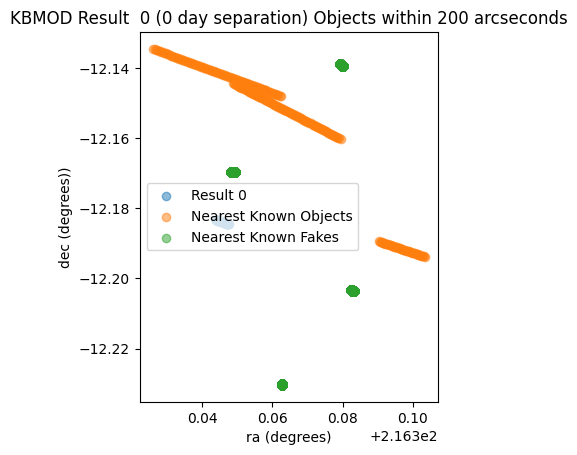

In [74]:
plot_res_with_nearby_objs(results,0, trajectories, fakes, known_objects, "RA_42.0", "Dec_42.0", 200)

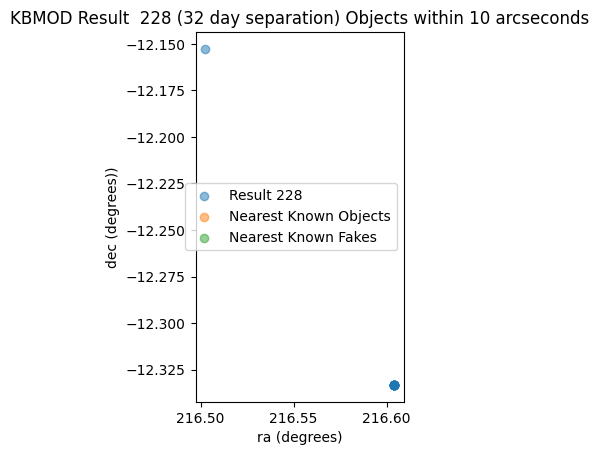

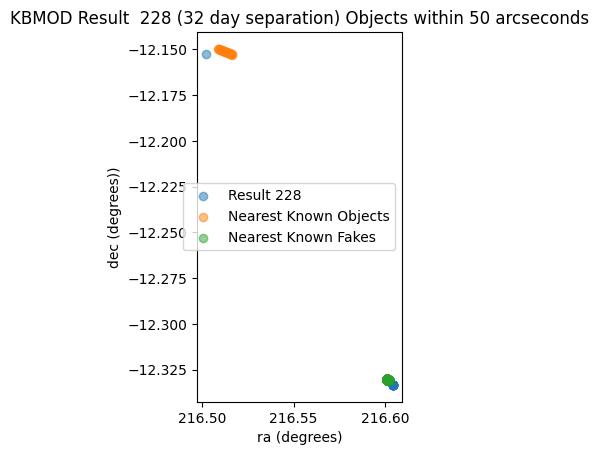

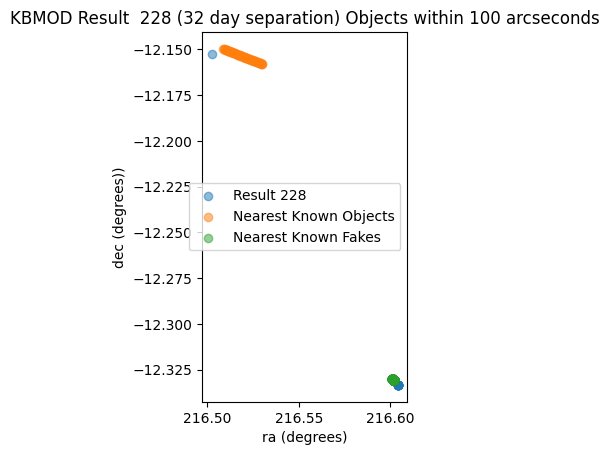

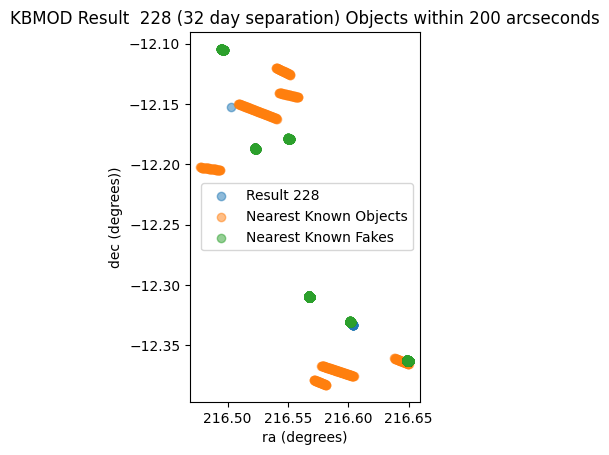

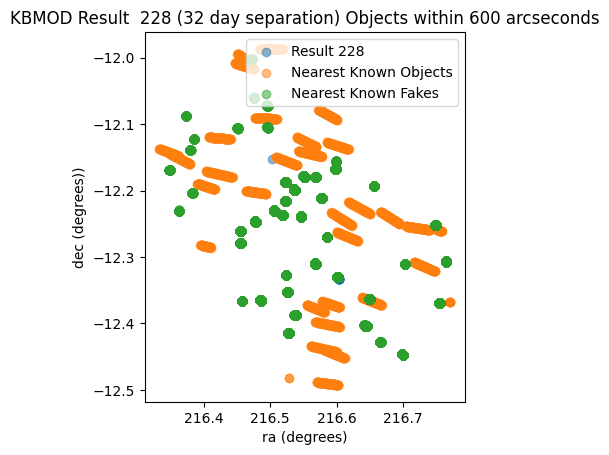

In [68]:
# For each separation limit in arcseconds, generate the plot.
for seplimit in [10, 50, 100, 200, 600]:
    plot_res_with_nearby_objs(results, 228, trajectories, fakes, known_objects, "RA_42.0", "Dec_42.0", seplimit)

In [69]:
multi_night_results = []
for i in range(len(results)):
    if results[i]["num_days"] >= 2:
        multi_night_results.append(i)
        
# Lol what a name
possible_discovery = []
for i in multi_night_results:
    if i not in result_start_to_fakes and i not in result_end_to_fakes:
        possible_discovery.append(i)
        
print(len(possible_discovery))
possible_discovery
        

29


[59,
 80,
 108,
 165,
 175,
 194,
 195,
 198,
 199,
 209,
 212,
 216,
 223,
 228,
 235,
 249,
 255,
 261,
 274,
 275,
 277,
 286,
 292,
 293,
 316,
 332,
 334,
 376,
 403]

/astro/users/wbeebe/.conda/envs/kbmod_new_wu/lib/python3.12/site-packages/kbmod/analysis/plotting.py:448: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(layout="constrained")


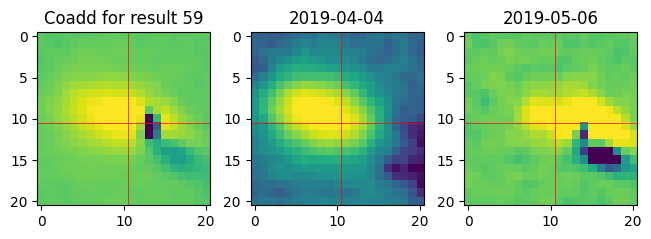

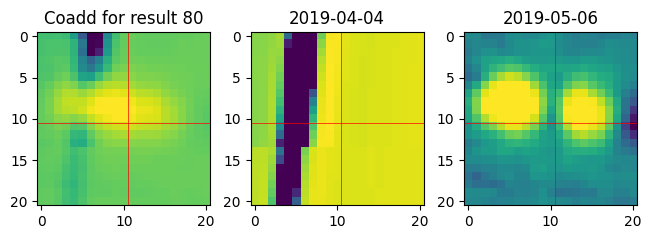

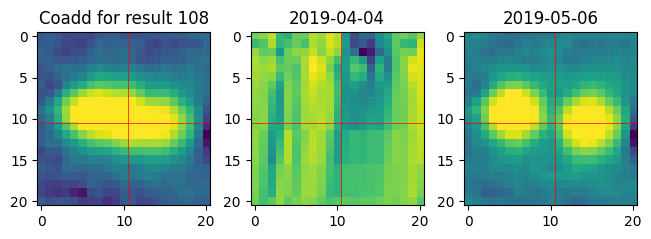

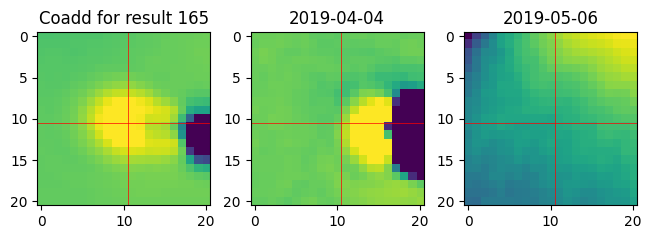

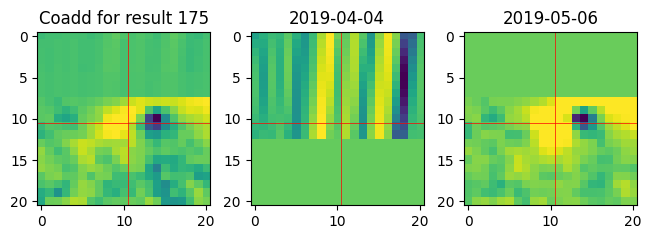

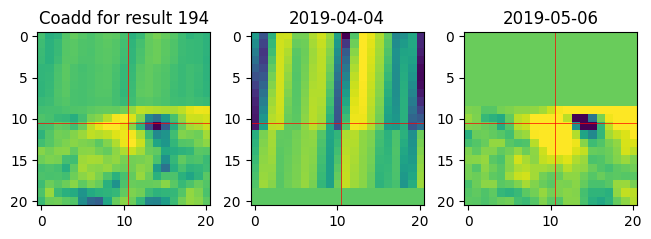

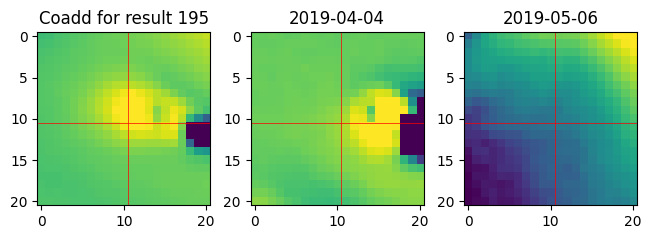

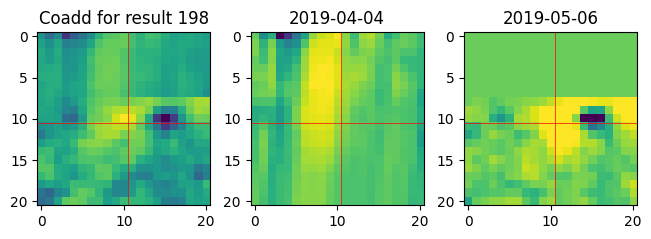

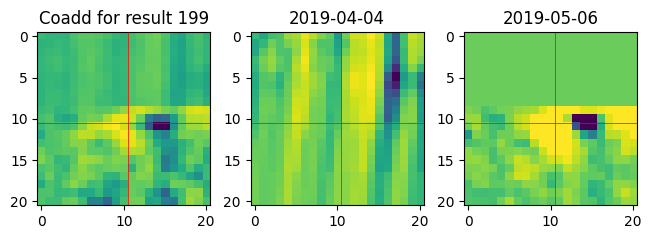

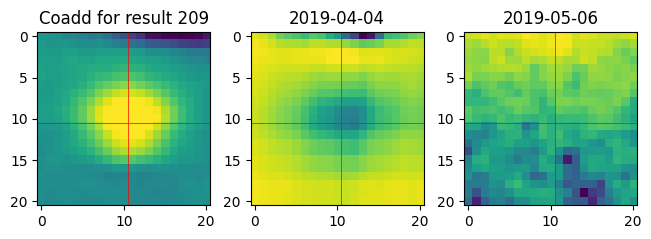

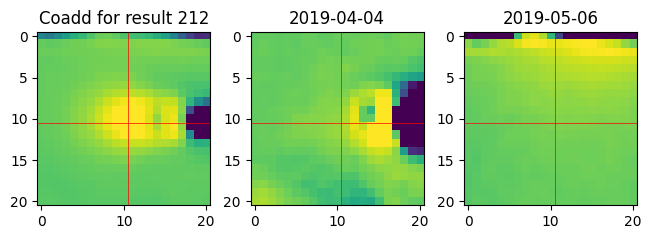

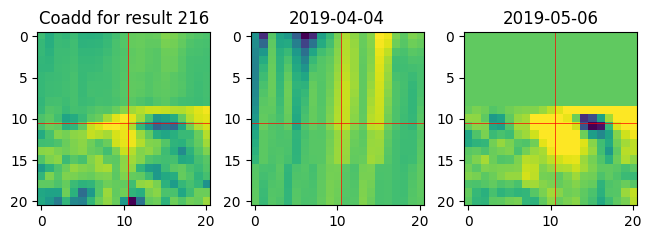

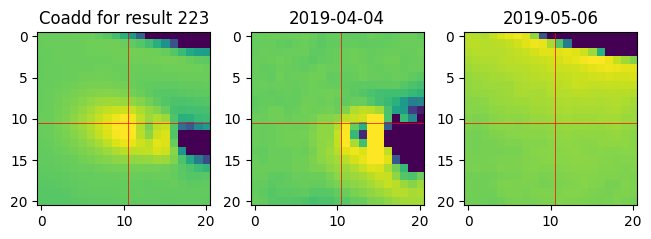

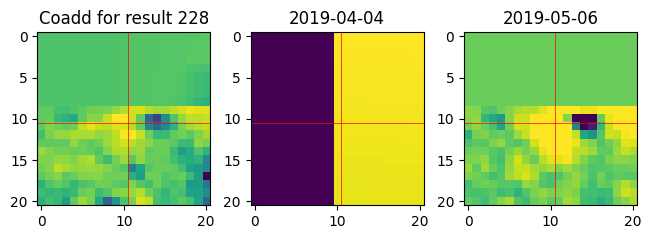

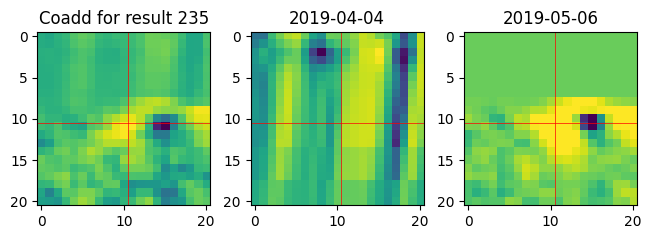

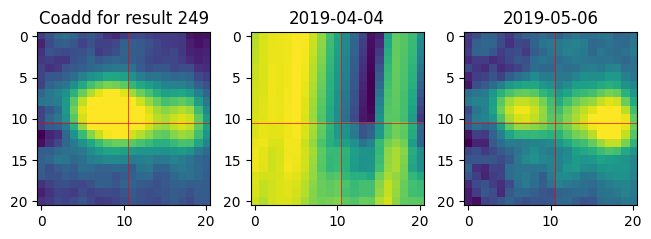

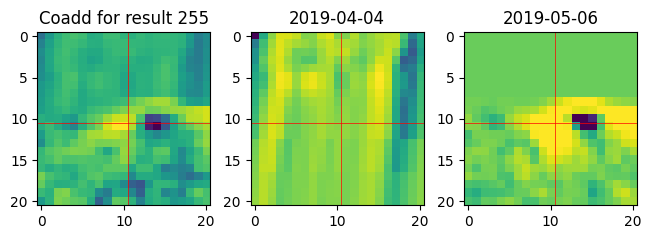

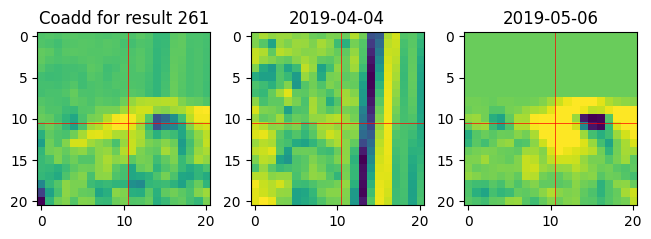

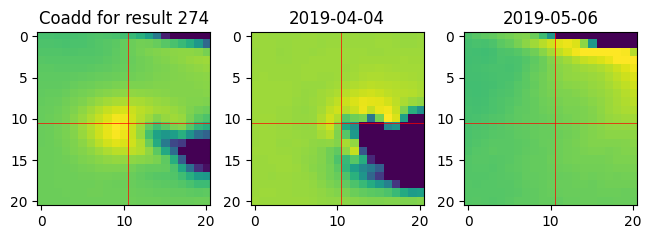

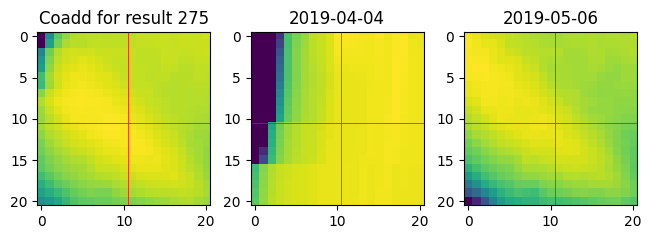

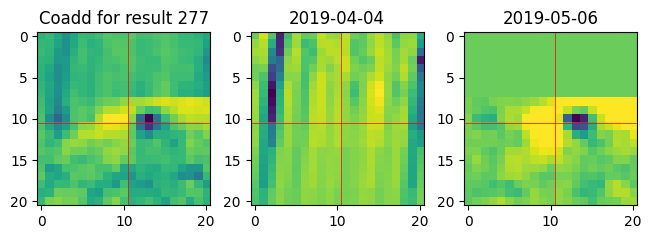

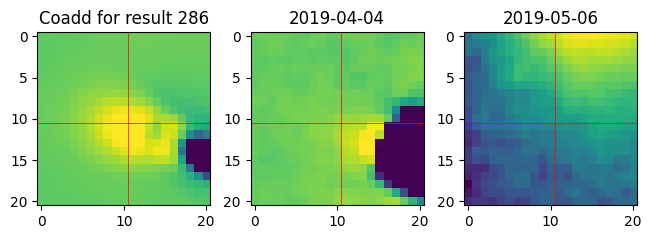

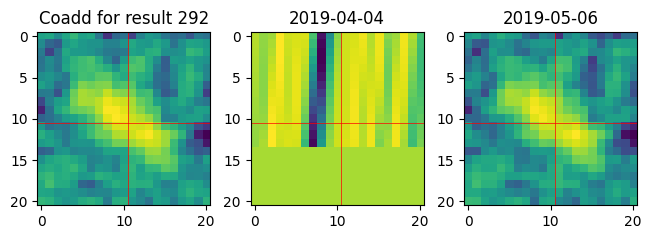

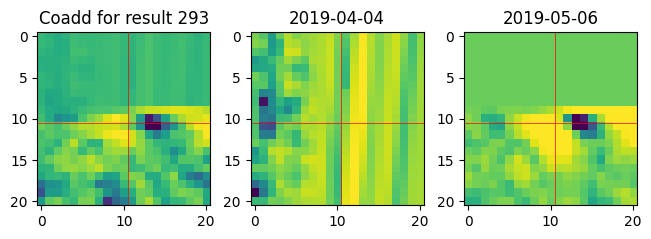

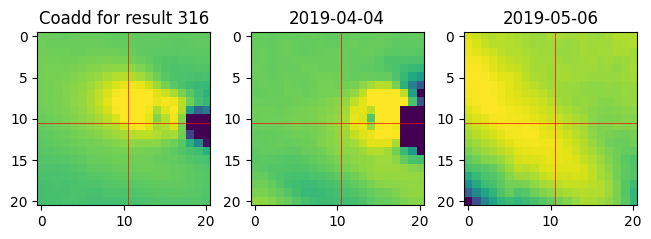

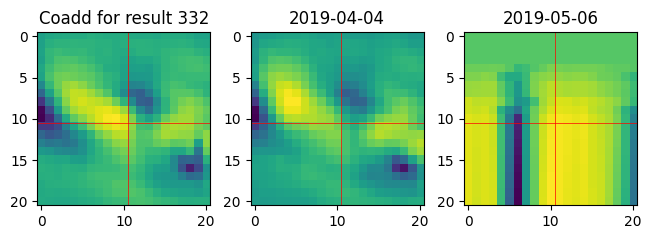

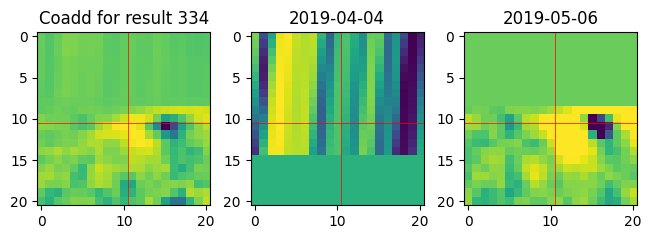

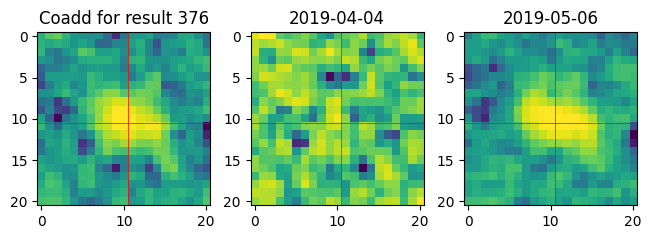

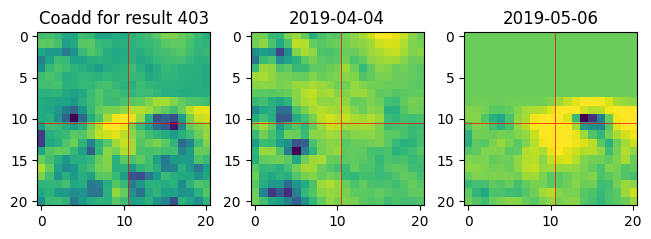

In [44]:
for idx in possible_discovery:
    plot_daily_coadds(results, idx)

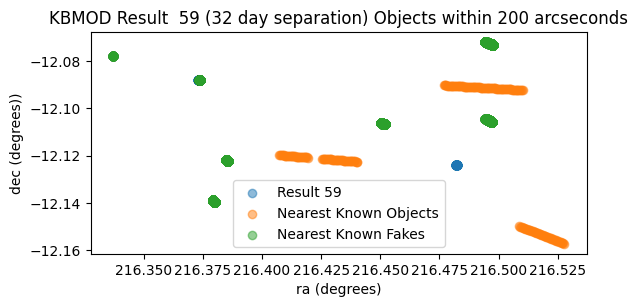

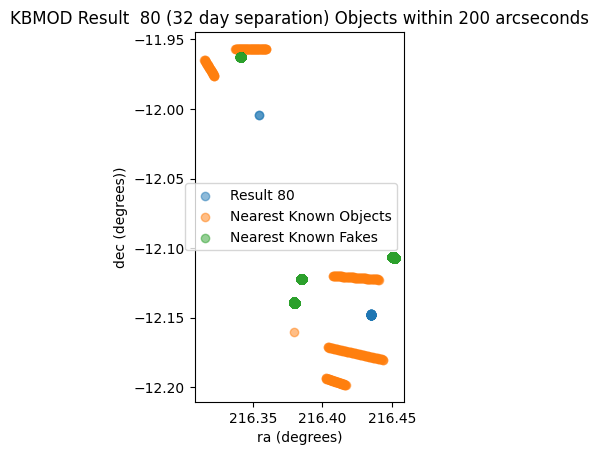

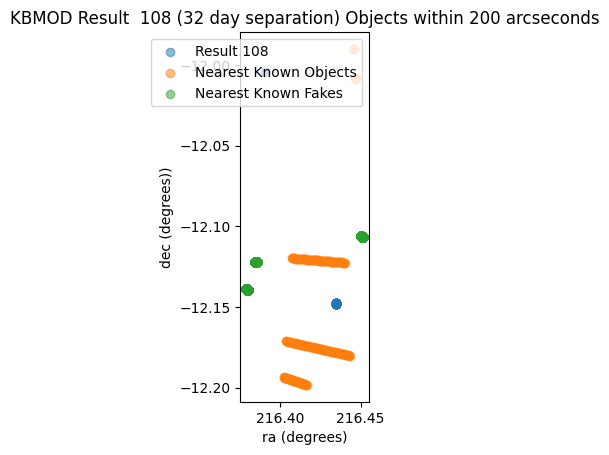

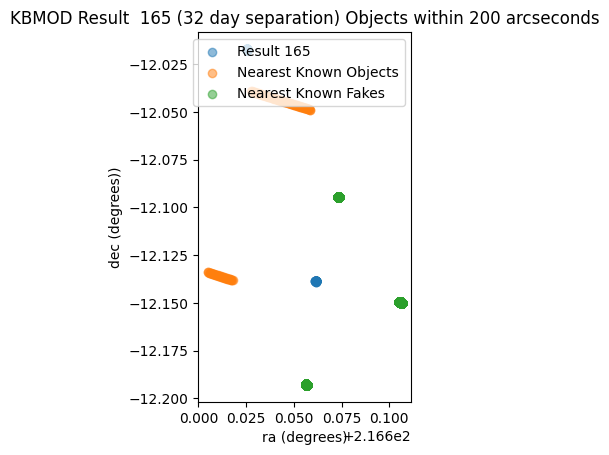

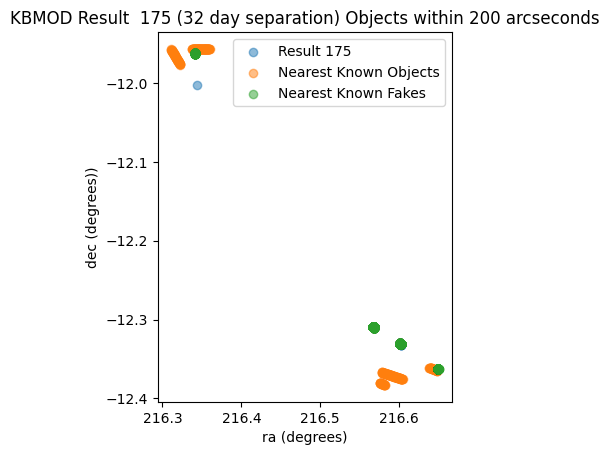

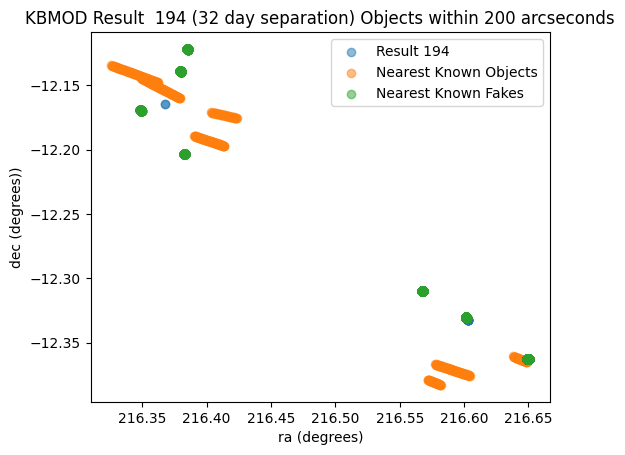

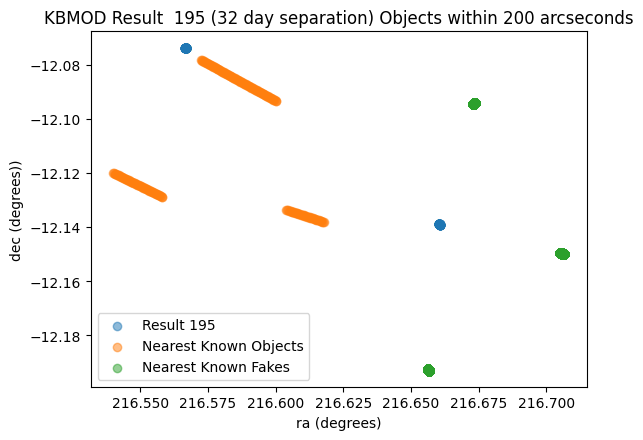

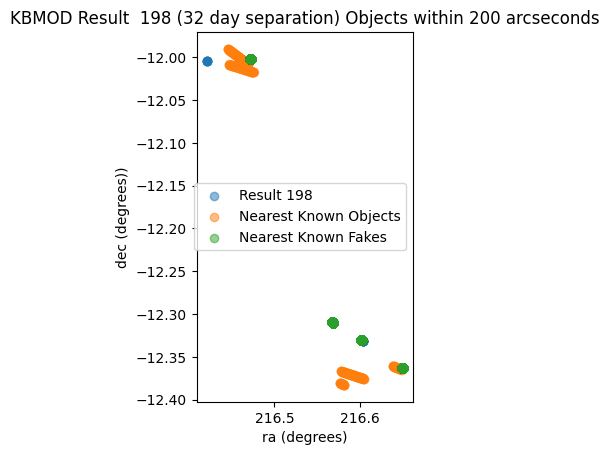

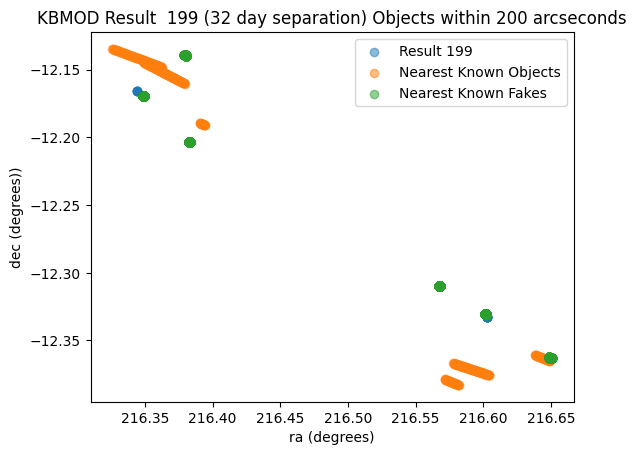

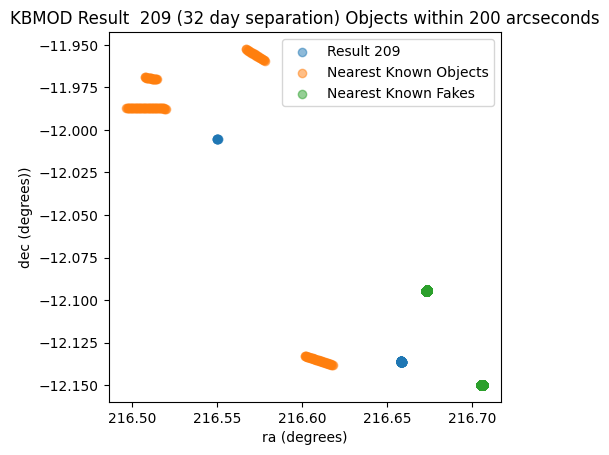

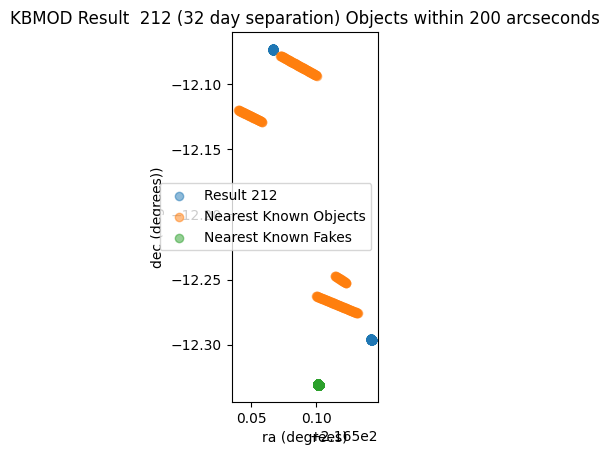

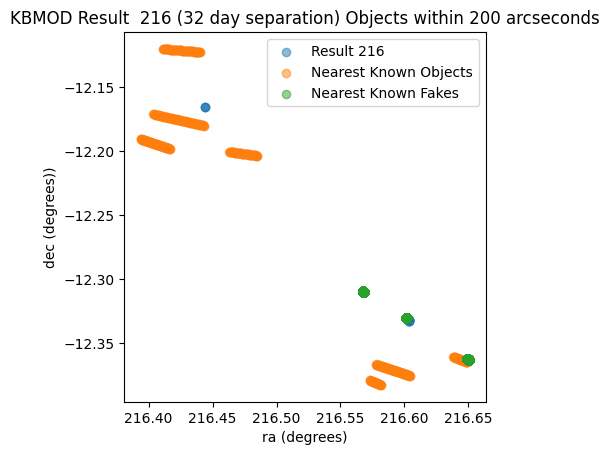

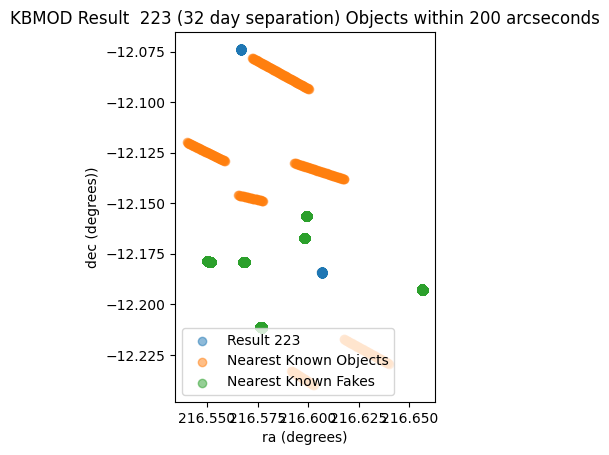

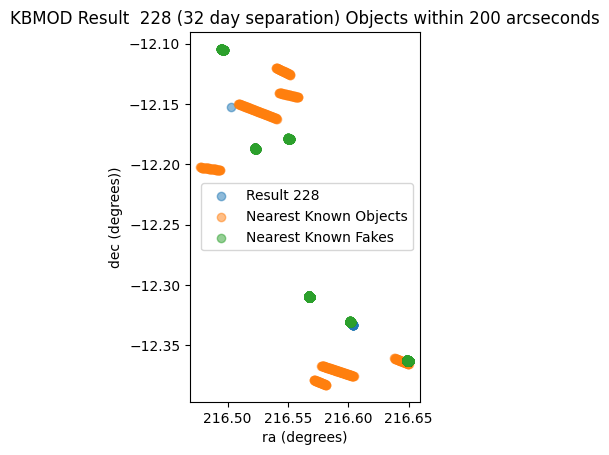

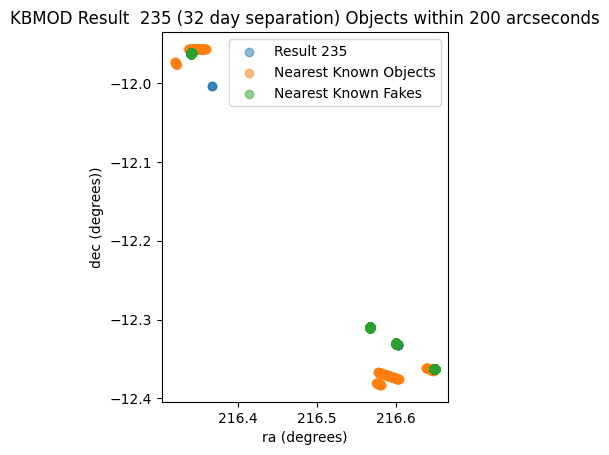

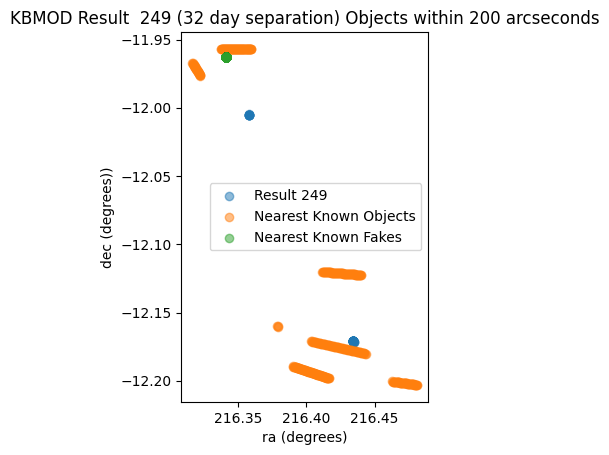

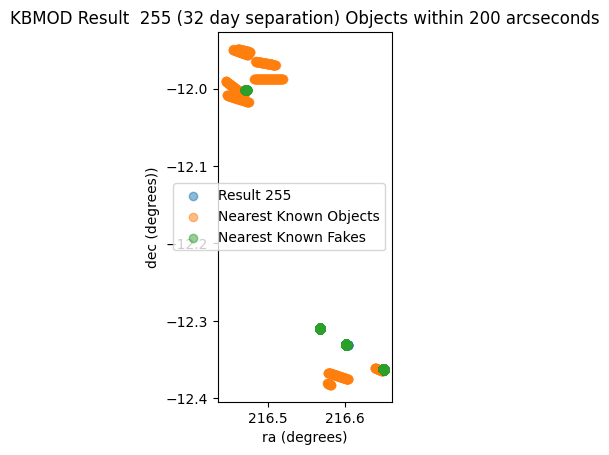

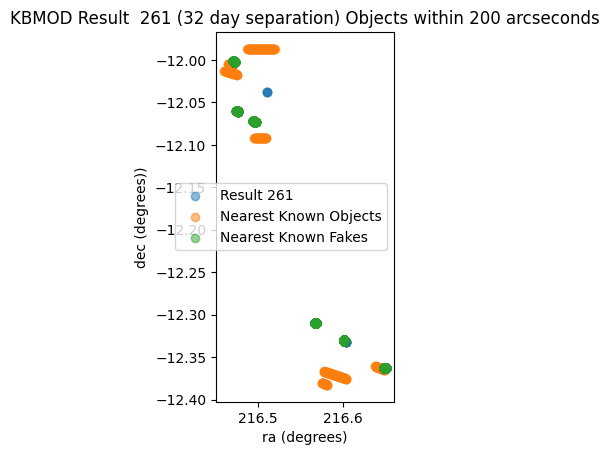

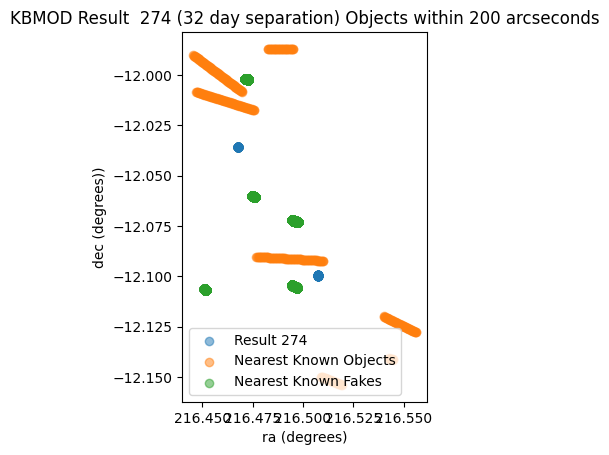

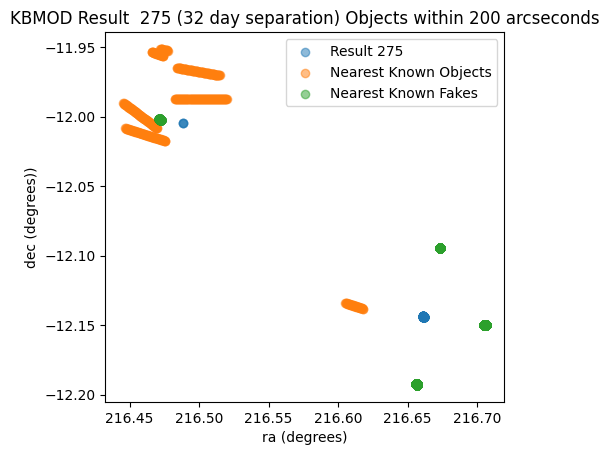

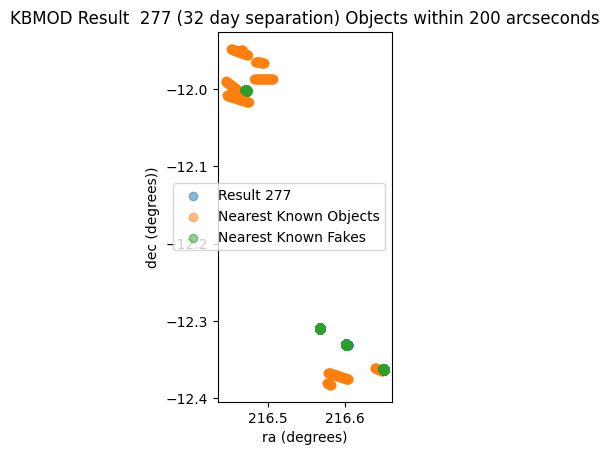

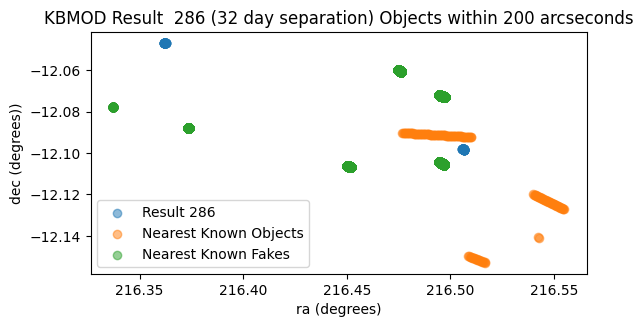

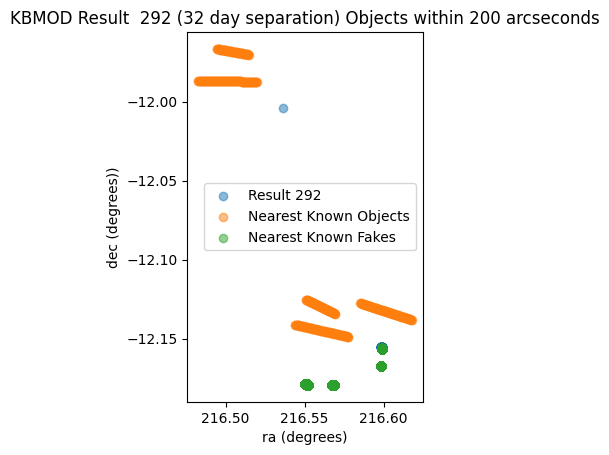

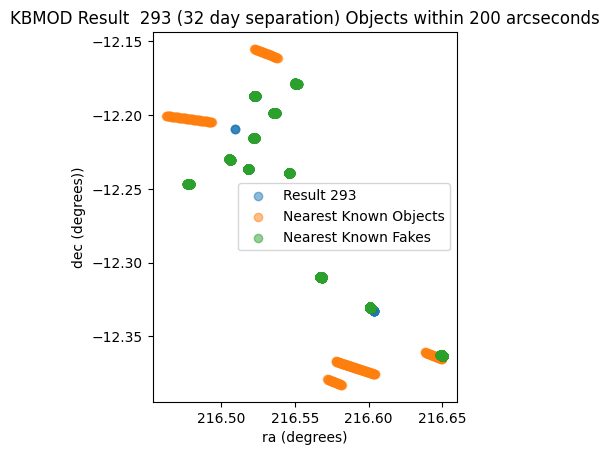

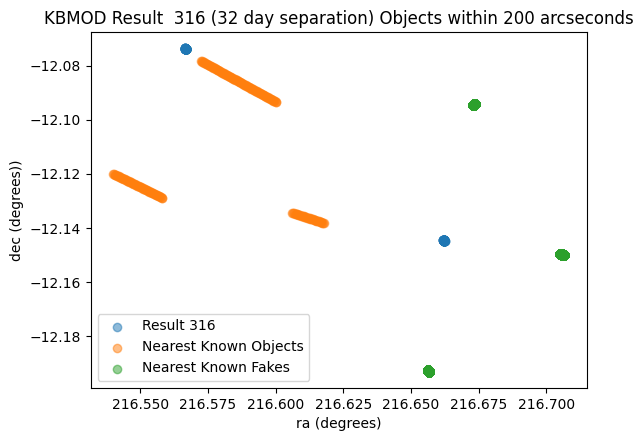

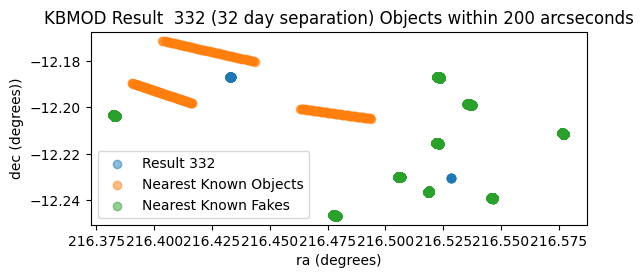

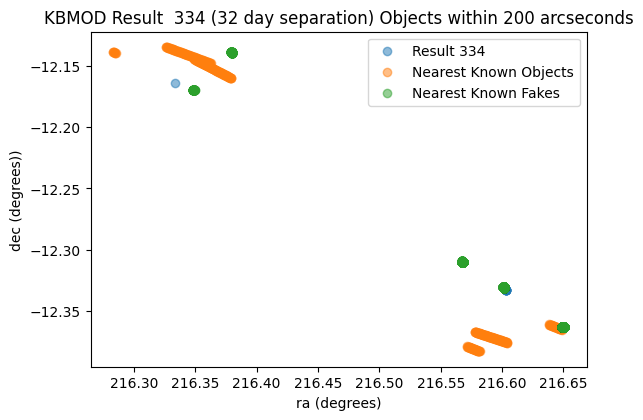

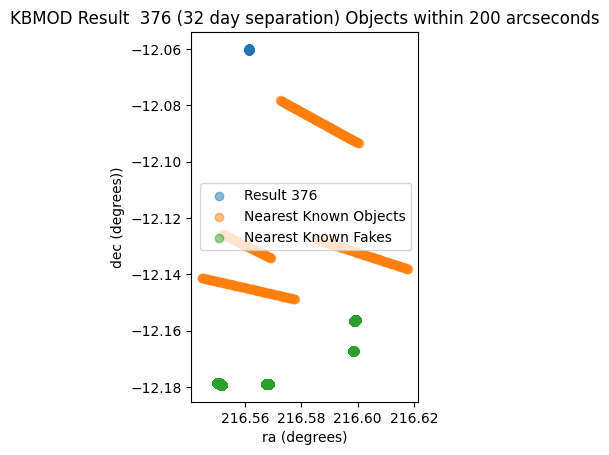

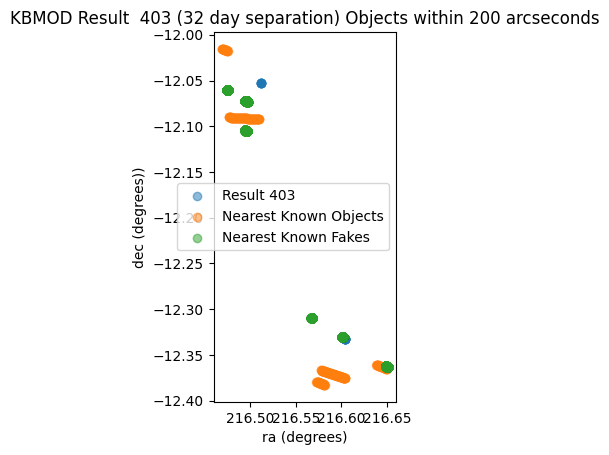

In [75]:
# For each separation limit in arcseconds, generate the plot.
for idx in possible_discovery:
    plot_res_with_nearby_objs(results, idx, trajectories, fakes, known_objects, "RA_42.0", "Dec_42.0", 200)